<H1>Deep Learning Project


Using Pyhton (3.11.4)

In [5]:
pip freeze > requirements.txt


Note: you may need to restart the kernel to use updated packages.


Imports

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, regularizers
import nltk
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


import pickle

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Federico\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
pip show scikit-learn

Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: c:\Users\Federico\anaconda3\Lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: daal4py, imbalanced-learn, librosa, mlxtend, scikit-learn-intelex
Note: you may need to restart the kernel to use updated packages.


Loading in the dataset: Twitter Emotions

In [2]:
#Loading in dataset
df = pd.read_csv('dataset(clean).csv')

print(df.head())

        Emotion                                            Content  \
0  disappointed  oh fuck did i wrote fil grinningfacewithsweat ...   
1  disappointed                       i feel nor am i shamed by it   
2  disappointed  i had been feeling a little bit defeated by th...   
3         happy  imagine if that reaction guy that called jj kf...   
4  disappointed  i wouldnt feel burdened so that i would live m...   

                                    Original Content  
0  b'RT @Davbingodav: @mcrackins Oh fuck.... did ...  
1                       i feel nor am i shamed by it  
2  i had been feeling a little bit defeated by th...  
3  b"@KSIOlajidebt imagine if that reaction guy t...  
4  i wouldnt feel burdened so that i would live m...  


Creating the datasets im gonna use to train and test.

Going to test on both clean and unclean

In [3]:
#creating a df with only the clean text and the label
dfClean = df[['Emotion', 'Content']]
print(dfClean.head())

        Emotion                                            Content
0  disappointed  oh fuck did i wrote fil grinningfacewithsweat ...
1  disappointed                       i feel nor am i shamed by it
2  disappointed  i had been feeling a little bit defeated by th...
3         happy  imagine if that reaction guy that called jj kf...
4  disappointed  i wouldnt feel burdened so that i would live m...


In [4]:
#Using unclean text
dfUnclean = df[['Emotion', 'Original Content']]
print(dfUnclean.head())

        Emotion                                   Original Content
0  disappointed  b'RT @Davbingodav: @mcrackins Oh fuck.... did ...
1  disappointed                       i feel nor am i shamed by it
2  disappointed  i had been feeling a little bit defeated by th...
3         happy  b"@KSIOlajidebt imagine if that reaction guy t...
4  disappointed  i wouldnt feel burdened so that i would live m...


Let's check the dataset to see if it is balanced

In [5]:
print(dfClean['Emotion'].value_counts())

disappointed    313714
happy           301871
angry           300990
Name: Emotion, dtype: int64


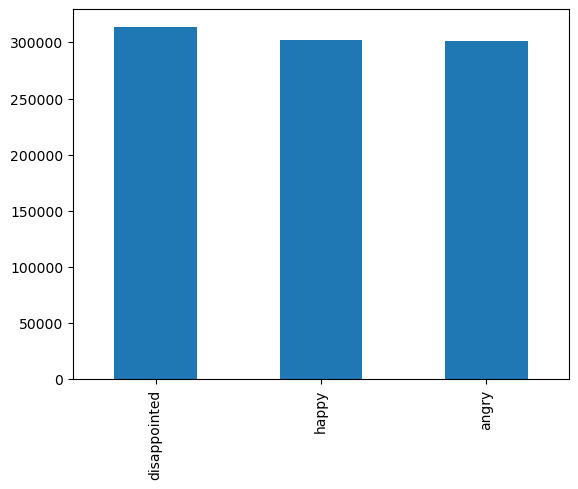

In [5]:
#plotting the distribution of the emotions
dfClean['Emotion'].value_counts().plot(kind='bar')
plt.show()


Lets split our training, validation and testing sets

Training set: 60% 

Validation set: 20%

Test set: 20%

In [6]:
# Split the data into training and test sets
df_train, df_test = train_test_split(dfClean, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [7]:
#split df unclean into train val and test
df_train_unclean, df_test_unclean = train_test_split(dfUnclean, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
df_train_unclean, df_val_unclean = train_test_split(df_train_unclean, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

Now lets preprocesses our data slightly to improve performance.

I decided to used a lemantazizer to reduce the size of the texxt representation, it has also been seen to improve accuracy for text classification.

In [8]:
def preprocess_data(df_train, df_val, df_test, max_len=100):#Keeping max length at 100 due to memory constraints
 # Check if 'Content' or 'Original Content' column exists in the DataFrame
    content_column = 'Content' if 'Content' in df_train.columns else 'Original Content' if 'Original Content' in df_train.columns else None

    # Initialize a lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatize the text data in each set
    df_train[content_column] = df_train[content_column].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    df_val[content_column] = df_val[content_column].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    df_test[content_column] = df_test[content_column].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

    # Initialize a tokenizer
    tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')

    # Fit the tokenizer on the training data
    tokenizer.fit_on_texts(df_train[content_column])

    # Tokenize and pad the text data in each set
    X_train = pad_sequences(tokenizer.texts_to_sequences(df_train[content_column]), maxlen=max_len)
    X_val = pad_sequences(tokenizer.texts_to_sequences(df_val[content_column]), maxlen=max_len)
    X_test = pad_sequences(tokenizer.texts_to_sequences(df_test[content_column]), maxlen=max_len)

    # Convert the labels to integers
    Y_train = df_train['Emotion'].astype('category').cat.codes
    Y_val = df_val['Emotion'].astype('category').cat.codes
    Y_test = df_test['Emotion'].astype('category').cat.codes 

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, tokenizer

In [9]:
X_train_clean, Y_train_clean, X_val_clean, Y_val_clean, X_test_clean, Y_test_clean, tokenizer_clean = preprocess_data(df_train, df_val, df_test)
X_train_unclean, Y_train_unclean, X_val_unclean, Y_val_unclean, X_test_unclean, Y_test_unclean, tokenizer_unclean = preprocess_data(df_train_unclean, df_val_unclean, df_test_unclean)

In [26]:
file_name = "test_splits_clean.pkl"

# Open the file for writing
with open(file_name, 'wb') as file_obj:
    pickle.dump((X_test_clean, Y_test_clean), file_obj)

In [45]:
file_name = "test_splits_unclean.pkl"

# Open the file for writing
with open(file_name, 'wb') as file_obj:
    pickle.dump((X_test_unclean, Y_test_unclean), file_obj)

Lets Define our models

In [10]:
max_len = 100

Basic CNN model

In [33]:
modelCNN1 = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # CNN layer
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    
    # Global Average Pooling layer
    tf.keras.layers.GlobalAveragePooling1D(),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelCNN1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 32)           320000    
                                                                 
 conv1d_9 (Conv1D)           (None, 96, 64)            10304     
                                                                 
 global_average_pooling1d_5  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_10 (Dense)            (None, 3)                 195       
                                                                 
Total params: 330499 (1.26 MB)
Trainable params: 330499 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
# Compile the model
modelCNN1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
historyCNN1 = modelCNN1.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)  

Epoch 1/5
4297/4297 [==============================] - 98s 22ms/step - loss: 0.3630 - accuracy: 0.8572 - val_loss: 0.2624 - val_accuracy: 0.8950
Epoch 2/5
4297/4297 [==============================] - 93s 22ms/step - loss: 0.2446 - accuracy: 0.9020 - val_loss: 0.2502 - val_accuracy: 0.8979
Epoch 3/5
4297/4297 [==============================] - 94s 22ms/step - loss: 0.2291 - accuracy: 0.9063 - val_loss: 0.2449 - val_accuracy: 0.8993
Epoch 4/5
4297/4297 [==============================] - 95s 22ms/step - loss: 0.2198 - accuracy: 0.9094 - val_loss: 0.2437 - val_accuracy: 0.8994
Epoch 5/5
4297/4297 [==============================] - 97s 23ms/step - loss: 0.2128 - accuracy: 0.9120 - val_loss: 0.2450 - val_accuracy: 0.8991


In [36]:
modelCNN1.save('modelCNN1.h5')

c:\Users\Federico\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
modelCNN = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # CNN layer
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),

     # Flatten layer
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(64, activation='relu'),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelCNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 32)           320000    
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 24, 64)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense_12 (Dense)            (None, 64)                98368     
                                                                 
 dense_13 (Dense)            (None, 3)                 195       
                                                      

In [29]:
# Compile the model
modelCNN.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
historyCNN = modelCNN.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)  

Epoch 1/5
4297/4297 [==============================] - 98s 23ms/step - loss: 0.2135 - accuracy: 0.9095 - val_loss: 0.2162 - val_accuracy: 0.9066
Epoch 2/5
4297/4297 [==============================] - 86s 20ms/step - loss: 0.1907 - accuracy: 0.9190 - val_loss: 0.2185 - val_accuracy: 0.9060
Epoch 3/5
4297/4297 [==============================] - 87s 20ms/step - loss: 0.1714 - accuracy: 0.9279 - val_loss: 0.2241 - val_accuracy: 0.9057
Epoch 4/5
4297/4297 [==============================] - 84s 20ms/step - loss: 0.1526 - accuracy: 0.9365 - val_loss: 0.2394 - val_accuracy: 0.9046
Epoch 5/5
4297/4297 [==============================] - 84s 19ms/step - loss: 0.1359 - accuracy: 0.9442 - val_loss: 0.2644 - val_accuracy: 0.9014


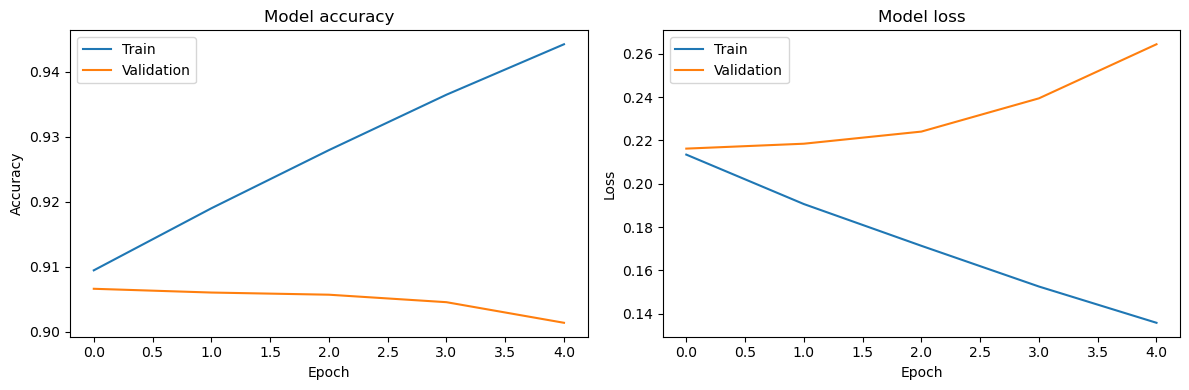

In [69]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyCNN.history['accuracy'])
plt.plot(historyCNN.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyCNN.history['loss'])
plt.plot(historyCNN.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

CNN with Tanh

In [37]:
modelCNNTanh = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # CNN layer
    tf.keras.layers.Conv1D(64, 5, activation='tanh'),
    tf.keras.layers.MaxPooling1D(pool_size=4),

     # Flatten layer
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(64, activation='tanh'),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelCNNTanh.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 32)           320000    
                                                                 
 conv1d_7 (Conv1D)           (None, 96, 64)            10304     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 24, 64)            0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 1536)              0         
                                                                 
 dense_5 (Dense)             (None, 64)                98368     
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                                      

In [38]:
# Compile the model
modelCNNTanh.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
historyCNNTanh = modelCNNTanh.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)  

Epoch 1/5
4297/4297 [==============================] - 175s 40ms/step - loss: 0.2764 - accuracy: 0.8841 - val_loss: 0.2434 - val_accuracy: 0.8982
Epoch 2/5
4297/4297 [==============================] - 154s 36ms/step - loss: 0.2205 - accuracy: 0.9082 - val_loss: 0.2372 - val_accuracy: 0.8995
Epoch 3/5
4297/4297 [==============================] - 157s 37ms/step - loss: 0.1934 - accuracy: 0.9196 - val_loss: 0.2344 - val_accuracy: 0.9014
Epoch 4/5
4297/4297 [==============================] - 161s 37ms/step - loss: 0.1690 - accuracy: 0.9305 - val_loss: 0.2484 - val_accuracy: 0.8960
Epoch 5/5
4297/4297 [==============================] - 157s 37ms/step - loss: 0.1486 - accuracy: 0.9396 - val_loss: 0.2666 - val_accuracy: 0.8962


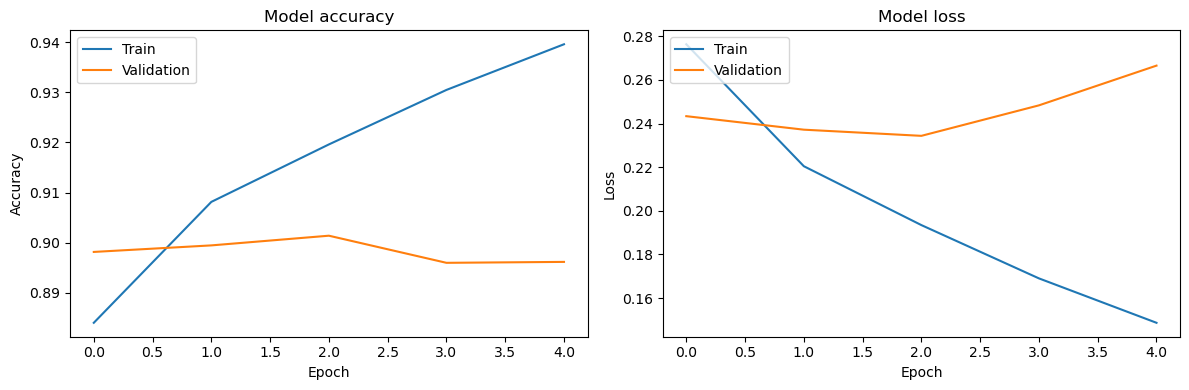

In [39]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyCNNTanh.history['accuracy'])
plt.plot(historyCNNTanh.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyCNNTanh.history['loss'])
plt.plot(historyCNNTanh.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

CNN with sigmoid

In [40]:
modelCNNSigmoid = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # CNN layer
    tf.keras.layers.Conv1D(64, 5, activation='tanh'),
    tf.keras.layers.MaxPooling1D(pool_size=4),

     # Flatten layer
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(64, activation='tanh'),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelCNNSigmoid.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 32)           320000    
                                                                 
 conv1d_8 (Conv1D)           (None, 96, 64)            10304     
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 24, 64)            0         
 g1D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 1536)              0         
                                                                 
 dense_7 (Dense)             (None, 64)                98368     
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                      

In [41]:
# Compile the model
modelCNNSigmoid.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
historyCNNSigmoid = modelCNNSigmoid.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)  

Epoch 1/5
4297/4297 [==============================] - 150s 34ms/step - loss: 0.2765 - accuracy: 0.8836 - val_loss: 0.2430 - val_accuracy: 0.8986
Epoch 2/5
4297/4297 [==============================] - 148s 34ms/step - loss: 0.2198 - accuracy: 0.9083 - val_loss: 0.2348 - val_accuracy: 0.9010
Epoch 3/5
4297/4297 [==============================] - 149s 35ms/step - loss: 0.1923 - accuracy: 0.9200 - val_loss: 0.2325 - val_accuracy: 0.9025
Epoch 4/5
4297/4297 [==============================] - 154s 36ms/step - loss: 0.1682 - accuracy: 0.9306 - val_loss: 0.2451 - val_accuracy: 0.9011
Epoch 5/5
4297/4297 [==============================] - 115s 27ms/step - loss: 0.1483 - accuracy: 0.9394 - val_loss: 0.2580 - val_accuracy: 0.8982


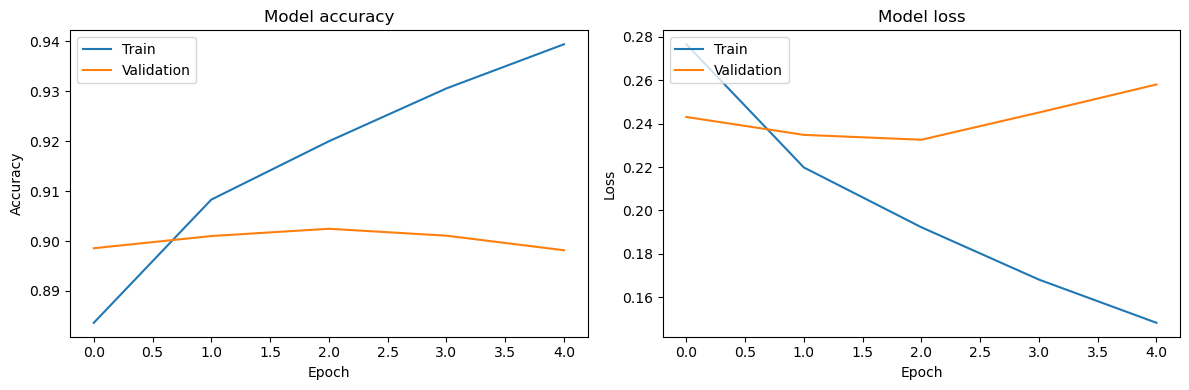

In [42]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyCNNSigmoid.history['accuracy'])
plt.plot(historyCNNSigmoid.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyCNNSigmoid.history['loss'])
plt.plot(historyCNNSigmoid.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [44]:
#save models
modelCNNSigmoid.save('CNN_model_Sigmoid')
modelCNNTanh.save('CNN_model_Tanh')

INFO:tensorflow:Assets written to: CNN_model_Sigmoid\assets


INFO:tensorflow:Assets written to: CNN_model_Sigmoid\assets


INFO:tensorflow:Assets written to: CNN_model_Tanh\assets


INFO:tensorflow:Assets written to: CNN_model_Tanh\assets


Basic LSTM model

In [30]:
modelLSTM = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # LSTM layers
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelLSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 32)           320000    
                                                                 
 lstm_20 (LSTM)              (None, 100, 64)           24832     
                                                                 
 lstm_21 (LSTM)              (None, 32)                12416     
                                                                 
 dense_14 (Dense)            (None, 3)                 99        
                                                                 
Total params: 357347 (1.36 MB)
Trainable params: 357347 (1.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Compile the model
modelLSTM.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
historyLSTM = modelLSTM.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)  

Epoch 1/5
4297/4297 [==============================] - 552s 128ms/step - loss: 0.2611 - accuracy: 0.8870 - val_loss: 0.2192 - val_accuracy: 0.9050
Epoch 2/5
4297/4297 [==============================] - 498s 116ms/step - loss: 0.2041 - accuracy: 0.9113 - val_loss: 0.2108 - val_accuracy: 0.9075
Epoch 3/5
4297/4297 [==============================] - 499s 116ms/step - loss: 0.1930 - accuracy: 0.9159 - val_loss: 0.2082 - val_accuracy: 0.9095
Epoch 4/5
4297/4297 [==============================] - 501s 117ms/step - loss: 0.1842 - accuracy: 0.9199 - val_loss: 0.2081 - val_accuracy: 0.9098
Epoch 5/5
4297/4297 [==============================] - 511s 119ms/step - loss: 0.1761 - accuracy: 0.9237 - val_loss: 0.2122 - val_accuracy: 0.9100


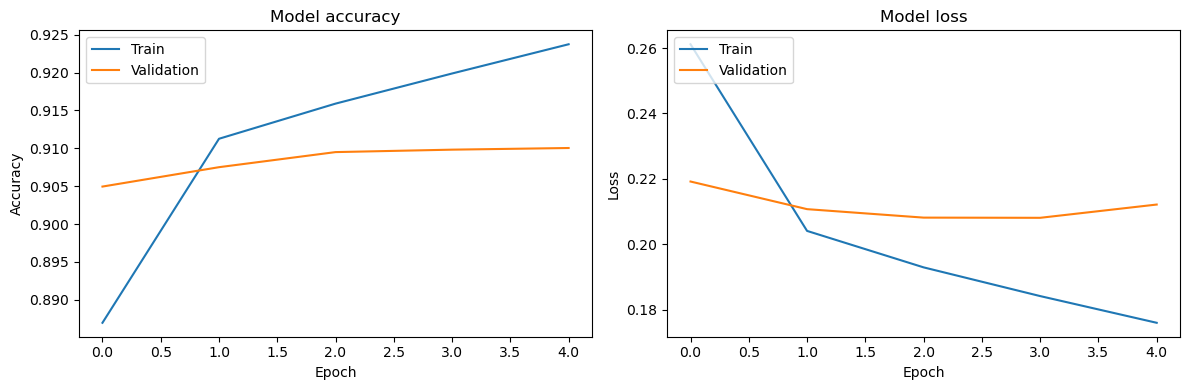

In [70]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyLSTM.history['accuracy'])
plt.plot(historyLSTM.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyLSTM.history['loss'])
plt.plot(historyLSTM.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Making the LSTM Bidirectional so it can do foward and back prop

In [28]:
modelLSTMBi = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # Bidirectional LSTM layers
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelLSTMBi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 32)           320000    
                                                                 
 bidirectional_4 (Bidirecti  (None, 100, 128)          49664     
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 411075 (1.57 MB)
Trainable params: 411075 (1.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Compile the model
modelLSTMBi.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
historyLSTMBi = modelLSTMBi.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)  

Epoch 1/5
4297/4297 [==============================] - 1260s 288ms/step - loss: 0.2688 - accuracy: 0.8850 - val_loss: 0.2220 - val_accuracy: 0.9036
Epoch 2/5
4297/4297 [==============================] - 1243s 289ms/step - loss: 0.2061 - accuracy: 0.9110 - val_loss: 0.2103 - val_accuracy: 0.9092
Epoch 3/5
4297/4297 [==============================] - 1254s 292ms/step - loss: 0.1926 - accuracy: 0.9160 - val_loss: 0.2074 - val_accuracy: 0.9093
Epoch 4/5
4297/4297 [==============================] - 1262s 294ms/step - loss: 0.1825 - accuracy: 0.9204 - val_loss: 0.2092 - val_accuracy: 0.9096
Epoch 5/5
4297/4297 [==============================] - 1270s 296ms/step - loss: 0.1739 - accuracy: 0.9244 - val_loss: 0.2131 - val_accuracy: 0.9093


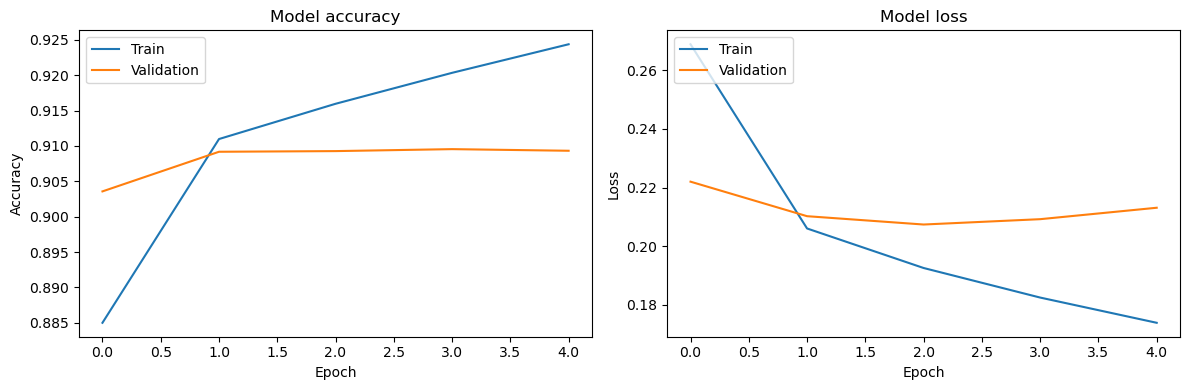

In [32]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyLSTMBi.history['accuracy'])
plt.plot(historyLSTMBi.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyLSTMBi.history['loss'])
plt.plot(historyLSTMBi.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [34]:
#save model
modelLSTMBi.save('LSTM_Bi_model')

INFO:tensorflow:Assets written to: LSTM_Bi_model\assets


INFO:tensorflow:Assets written to: LSTM_Bi_model\assets


Making a more LSTM model by adding an attention layer to hopefully improve its performance

In [34]:
# Input layer
inputs = tf.keras.Input(shape=(max_len,))
x = tf.keras.layers.Embedding(input_dim=10000, output_dim=32)(inputs)

# LSTM layers
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(x)

# MultiHeadAttention layer
mha_layer = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=32)
attention_output = mha_layer(x, x) 
# Add a GlobalAveragePooling1D layer after the Attention layer
pooled = tf.keras.layers.GlobalAveragePooling1D()(attention_output)

# Output layer
outputs = tf.keras.layers.Dense(3, activation='softmax')(pooled)

# Create model
modelLSTMAttention = tf.keras.Model(inputs=inputs, outputs=outputs)

# Print the model summary
modelLSTMAttention.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 100, 32)              320000    ['input_9[0][0]']             
                                                                                                  
 bidirectional_20 (Bidirect  (None, 100, 128)             49664     ['embedding_14[0][0]']        
 ional)                                                                                           
                                                                                                  
 bidirectional_21 (Bidirect  (None, 100, 64)              41216     ['bidirectional_20[0][0]

In [35]:
# Compile the model
modelLSTMAttention.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
historyLSTMAttention = modelLSTMAttention.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)  

Epoch 1/5
4297/4297 [==============================] - 1468s 340ms/step - loss: 0.2882 - accuracy: 0.8740 - val_loss: 0.2178 - val_accuracy: 0.9062
Epoch 2/5
4297/4297 [==============================] - 1539s 358ms/step - loss: 0.2049 - accuracy: 0.9115 - val_loss: 0.2126 - val_accuracy: 0.9066
Epoch 3/5
4297/4297 [==============================] - 1689s 393ms/step - loss: 0.1929 - accuracy: 0.9160 - val_loss: 0.2081 - val_accuracy: 0.9100
Epoch 4/5
4297/4297 [==============================] - 12546s 3s/step - loss: 0.1841 - accuracy: 0.9202 - val_loss: 0.2075 - val_accuracy: 0.9099
Epoch 5/5
4297/4297 [==============================] - 1654s 385ms/step - loss: 0.1747 - accuracy: 0.9241 - val_loss: 0.2100 - val_accuracy: 0.9094


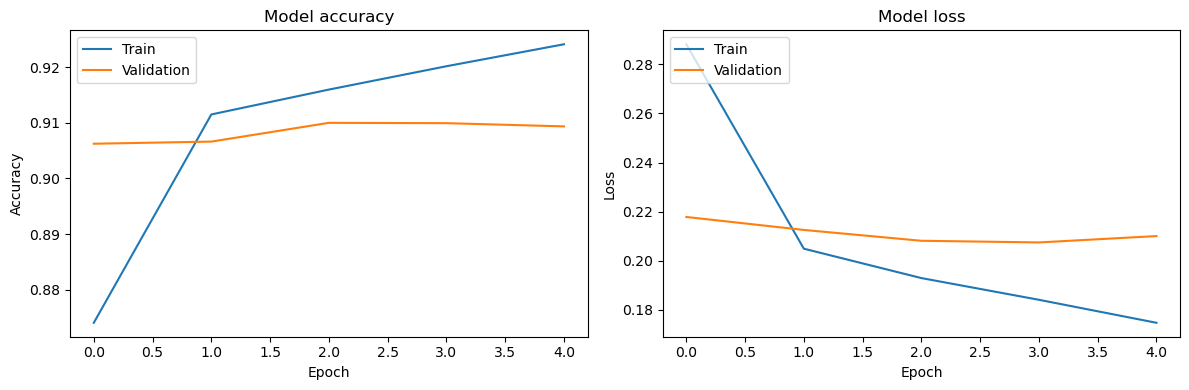

In [72]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyLSTMAttention.history['accuracy'])
plt.plot(historyLSTMAttention.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyLSTMAttention.history['loss'])
plt.plot(historyLSTMAttention.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

What if we move the attention layer in between my LSTM layers

In [36]:
# Input layer
inputs = tf.keras.Input(shape=(max_len,))
x = tf.keras.layers.Embedding(input_dim=10000, output_dim=32)(inputs)

# LSTM layers
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
mha_layer = tf.keras.layers.MultiHeadAttention(num_heads=3, key_dim=32)
attention_output = mha_layer(x, x) 
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(attention_output)
# Add a GlobalAveragePooling1D layer after the Attention layer
pooled = tf.keras.layers.GlobalAveragePooling1D()(x)

# Output layer
outputs = tf.keras.layers.Dense(3, activation='softmax')(pooled)

# Create model
modelLSTMAttentionBetween = tf.keras.Model(inputs=inputs, outputs=outputs)

# Print the model summary
modelLSTMAttentionBetween.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_15 (Embedding)    (None, 100, 32)              320000    ['input_10[0][0]']            
                                                                                                  
 bidirectional_22 (Bidirect  (None, 100, 128)             49664     ['embedding_15[0][0]']        
 ional)                                                                                           
                                                                                                  
 multi_head_attention_9 (Mu  (None, 100, 128)             49568     ['bidirectional_22[0][0]

In [37]:
# Compile the model
modelLSTMAttentionBetween.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
historyLSTMAttentionBetween = modelLSTMAttentionBetween.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)  

Epoch 1/5
4297/4297 [==============================] - 2227s 517ms/step - loss: 0.2937 - accuracy: 0.8731 - val_loss: 0.2208 - val_accuracy: 0.9055
Epoch 2/5
4297/4297 [==============================] - 2280s 531ms/step - loss: 0.2063 - accuracy: 0.9107 - val_loss: 0.2094 - val_accuracy: 0.9079
Epoch 3/5
4297/4297 [==============================] - 3471s 808ms/step - loss: 0.1958 - accuracy: 0.9151 - val_loss: 0.2069 - val_accuracy: 0.9098
Epoch 4/5
4297/4297 [==============================] - 32018s 7s/step - loss: 0.1880 - accuracy: 0.9184 - val_loss: 0.2077 - val_accuracy: 0.9104
Epoch 5/5
4297/4297 [==============================] - 2688s 625ms/step - loss: 0.1803 - accuracy: 0.9218 - val_loss: 0.2129 - val_accuracy: 0.9095


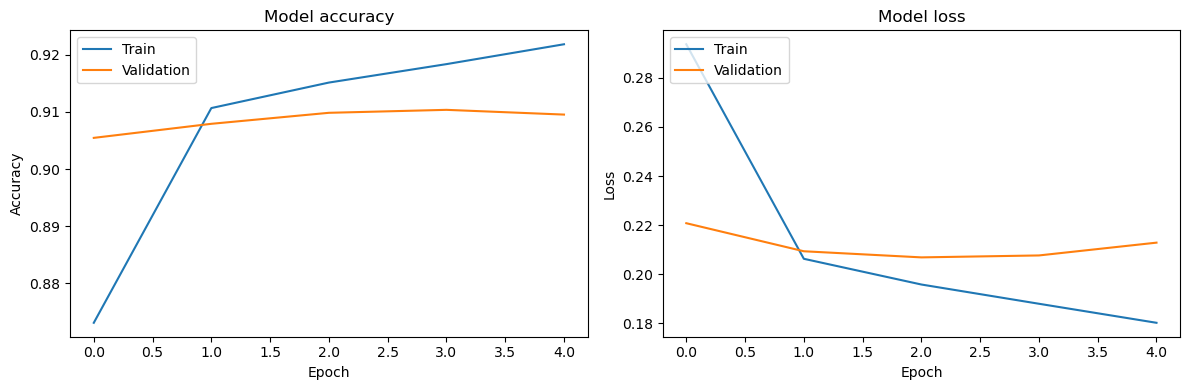

In [73]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyLSTMAttentionBetween.history['accuracy'])
plt.plot(historyLSTMAttentionBetween.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyLSTMAttentionBetween.history['loss'])
plt.plot(historyLSTMAttentionBetween.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Upping the heads on the multihead attention layer to see if performance improves

In [ ]:

epochs = 5
batch_size = 128

#dict to store accuracies
accuracy_per_heads = {}

for num_heads in range(5, 26, 5):
    # Create the model
    inputs = tf.keras.Input(shape=(max_len,))
    x = tf.keras.layers.Embedding(input_dim=10000, output_dim=32)(inputs)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
    mha_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=32)
    attention_output = mha_layer(x, x) 
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(attention_output)
    pooled = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(3, activation='softmax')(pooled)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_clean, Y_train_clean, epochs=epochs, batch_size=batch_size, validation_data=(X_val_clean, Y_val_clean))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_clean, Y_test_clean)
    
    # Store the accuracy in the dictionary
    accuracy_per_heads[num_heads] = accuracy

# Print the accuracy for each number of heads
for num_heads, accuracy in accuracy_per_heads.items():
    print(f'Number of heads: {num_heads}, Accuracy: {accuracy}')

Epoch 1/5
4297/4297 [==============================] - 1599s 371ms/step - loss: 0.3245 - accuracy: 0.8440 - val_loss: 0.2199 - val_accuracy: 0.9033
Epoch 2/5
4297/4297 [==============================] - 1594s 371ms/step - loss: 0.2078 - accuracy: 0.9106 - val_loss: 0.2116 - val_accuracy: 0.9085
Epoch 3/5
4297/4297 [==============================] - 1638s 381ms/step - loss: 0.1951 - accuracy: 0.9162 - val_loss: 0.2103 - val_accuracy: 0.9080
Epoch 4/5
4297/4297 [==============================] - 1634s 380ms/step - loss: 0.1863 - accuracy: 0.9198 - val_loss: 0.2075 - val_accuracy: 0.9094
Epoch 5/5
5729/5729 [==============================] - 226s 39ms/step - loss: 0.2086 - accuracy: 0.9106
Epoch 1/5
4297/4297 [==============================] - 2332s 541ms/step - loss: 0.2928 - accuracy: 0.8727 - val_loss: 0.2240 - val_accuracy: 0.9034
Epoch 2/5
4297/4297 [==============================] - 2354s 548ms/step - loss: 0.2067 - accuracy: 0.9111 - val_loss: 0.2101 - val_accuracy: 0.9085
Epoch 3/

Create the best LSTM Model form above

In [38]:
#making the best lstm model with attention
# Create the model
inputs = tf.keras.Input(shape=(max_len,))
x = tf.keras.layers.Embedding(input_dim=10000, output_dim=32)(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
mha_layer = tf.keras.layers.MultiHeadAttention(num_heads=5, key_dim=32)
attention_output = mha_layer(x, x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(attention_output)
pooled = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(pooled)
modelLSTMAttentionBest = tf.keras.Model(inputs=inputs, outputs=outputs)

modelLSTMAttentionBest.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_16 (Embedding)    (None, 100, 32)              320000    ['input_11[0][0]']            
                                                                                                  
 bidirectional_24 (Bidirect  (None, 100, 128)             49664     ['embedding_16[0][0]']        
 ional)                                                                                           
                                                                                                  
 multi_head_attention_10 (M  (None, 100, 128)             82528     ['bidirectional_24[0][0

In [39]:
#trani the model
modelLSTMAttentionBest.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

historyLSTMAttentionBest = modelLSTMAttentionBest.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)

Epoch 1/5
4297/4297 [==============================] - 2863s 664ms/step - loss: 0.2797 - accuracy: 0.8787 - val_loss: 0.2190 - val_accuracy: 0.9038
Epoch 2/5
4297/4297 [==============================] - 2898s 674ms/step - loss: 0.2054 - accuracy: 0.9114 - val_loss: 0.2103 - val_accuracy: 0.9087
Epoch 3/5
4297/4297 [==============================] - 3124s 727ms/step - loss: 0.1948 - accuracy: 0.9159 - val_loss: 0.2081 - val_accuracy: 0.9094
Epoch 4/5
4297/4297 [==============================] - 3113s 725ms/step - loss: 0.1867 - accuracy: 0.9190 - val_loss: 0.2091 - val_accuracy: 0.9080
Epoch 5/5
4297/4297 [==============================] - 3122s 727ms/step - loss: 0.1792 - accuracy: 0.9227 - val_loss: 0.2107 - val_accuracy: 0.9085


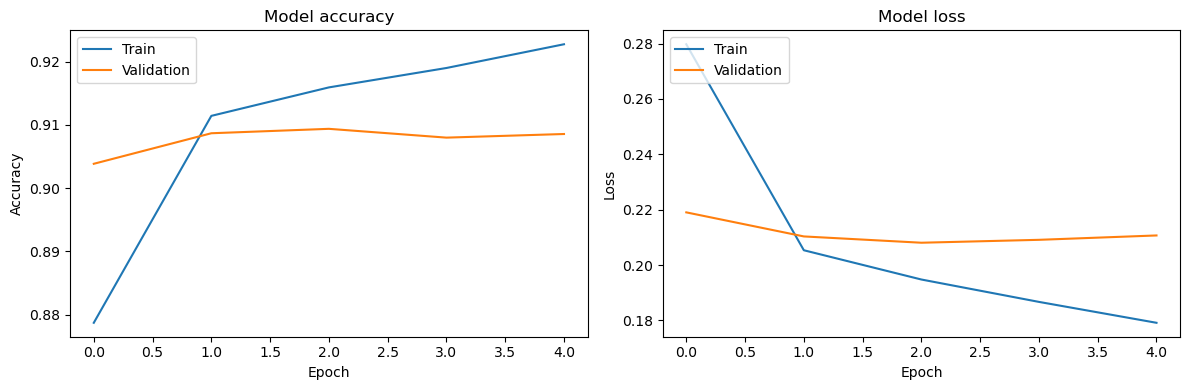

In [74]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyLSTMAttentionBest.history['accuracy'])
plt.plot(historyLSTMAttentionBest.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyLSTMAttentionBest.history['loss'])
plt.plot(historyLSTMAttentionBest.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Lets save the models

In [41]:
#save the models
modelCNN.save('CNN_model')
modelLSTM.save('LSTM_model')
modelLSTMBi.save('LSTM_Bi_model')
modelLSTMAttention.save('LSTM_Attention_model')
modelLSTMAttentionBetween.save('LSTM_Attention_Between_model')
modelLSTMAttentionBest.save('LSTM_Attention_Best_model')

INFO:tensorflow:Assets written to: CNN_model\assets


INFO:tensorflow:Assets written to: CNN_model\assets


INFO:tensorflow:Assets written to: LSTM_model\assets


INFO:tensorflow:Assets written to: LSTM_model\assets


INFO:tensorflow:Assets written to: LSTM_Bi_model\assets


INFO:tensorflow:Assets written to: LSTM_Bi_model\assets


INFO:tensorflow:Assets written to: LSTM_Attention_model\assets


INFO:tensorflow:Assets written to: LSTM_Attention_model\assets


INFO:tensorflow:Assets written to: LSTM_Attention_Between_model\assets


INFO:tensorflow:Assets written to: LSTM_Attention_Between_model\assets


INFO:tensorflow:Assets written to: LSTM_Attention_Best_model\assets


INFO:tensorflow:Assets written to: LSTM_Attention_Best_model\assets


Lets have some predictions

In [43]:
lemmatizer = WordNetLemmatizer()

# Test the model with a sample text
sample_text = "I am angry at my boss today for giving out to me"
sample_text = ' '.join([lemmatizer.lemmatize(word) for word in sample_text.split()])
sample_sequence = pad_sequences(tokenizer_clean.texts_to_sequences([sample_text]), maxlen=max_len)

# Predict the emotion
print("Probability of "+dfClean['Emotion'].value_counts().index[np.argmax(modelCNN.predict(sample_sequence)) -1]+ " is: " + str(np.max(modelCNN.predict(sample_sequence)))+" for the CNN model")
print("Probability of "+dfClean['Emotion'].value_counts().index[np.argmax(modelLSTM.predict(sample_sequence)) -1]+ " is: " + str(np.max(modelLSTM.predict(sample_sequence)))+" for the LSTM model")
print("Probability of "+dfClean['Emotion'].value_counts().index[np.argmax(modelLSTMAttention.predict(sample_sequence)) -1]+ " is: " + str(np.max(modelLSTMAttention.predict(sample_sequence)))+" for the attention model")
print("Probability of "+dfClean['Emotion'].value_counts().index[np.argmax(modelLSTMAttentionBest.predict(sample_sequence)) -1]+ " is: " + str(np.max(modelLSTMAttentionBest.predict(sample_sequence)))+" for the best attention model")

1/1 [==============================] - 0s 12ms/step
Probability of angry is: 0.9062389 for the CNN model
1/1 [==============================] - 0s 24ms/step
Probability of angry is: 0.9090168 for the LSTM model
1/1 [==============================] - 0s 20ms/step
Probability of angry is: 0.8320817 for the attention model
1/1 [==============================] - 0s 15ms/step
Probability of angry is: 0.8547482 for the best attention model


Now train them with the unclean data to see if we spot any chnages


In [45]:
#CNN model 

modelCNN2 = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # CNN layer
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),

     # Flatten layer
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(64, activation='relu'),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelCNN2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 32)           320000    
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 64)            10304     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 24, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1536)              0         
                                                                 
 dense_19 (Dense)            (None, 64)                98368     
                                                                 
 dense_20 (Dense)            (None, 3)                 195       
                                                      

In [46]:
#train with unclean
modelCNN2.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

historyCNN2 = modelCNN2.fit(X_train_unclean, Y_train_unclean,
                    validation_data=(X_val_unclean, Y_val_unclean),
                    epochs=5,  
                    batch_size=128)

Epoch 1/5
4297/4297 [==============================] - 124s 29ms/step - loss: 0.2570 - accuracy: 0.8894 - val_loss: 0.2188 - val_accuracy: 0.9038
Epoch 2/5
4297/4297 [==============================] - 119s 28ms/step - loss: 0.1991 - accuracy: 0.9138 - val_loss: 0.2110 - val_accuracy: 0.9079
Epoch 3/5
4297/4297 [==============================] - 109s 25ms/step - loss: 0.1769 - accuracy: 0.9240 - val_loss: 0.2181 - val_accuracy: 0.9065
Epoch 4/5
4297/4297 [==============================] - 102s 24ms/step - loss: 0.1552 - accuracy: 0.9339 - val_loss: 0.2305 - val_accuracy: 0.9044
Epoch 5/5
4297/4297 [==============================] - 102s 24ms/step - loss: 0.1346 - accuracy: 0.9436 - val_loss: 0.2565 - val_accuracy: 0.9013


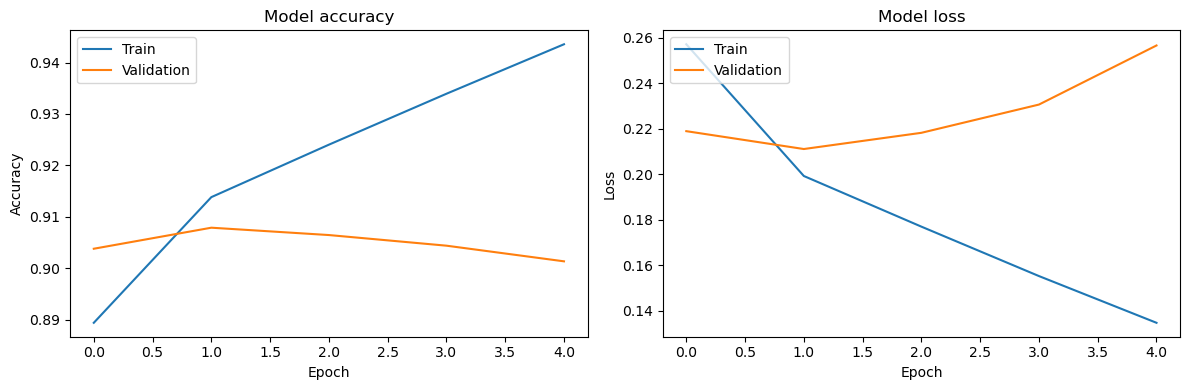

In [75]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyCNN2.history['accuracy'])
plt.plot(historyCNN2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyCNN2.history['loss'])
plt.plot(historyCNN2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [51]:
#cnn with tanh unclean
modelCNNTanh2 = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # CNN layer
    tf.keras.layers.Conv1D(64, 5, activation='tanh'),
    tf.keras.layers.MaxPooling1D(pool_size=4),

     # Flatten layer
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(64, activation='tanh'),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelCNNTanh2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 32)           320000    
                                                                 
 conv1d_12 (Conv1D)          (None, 96, 64)            10304     
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 24, 64)            0         
 ng1D)                                                           
                                                                 
 flatten_9 (Flatten)         (None, 1536)              0         
                                                                 
 dense_15 (Dense)            (None, 64)                98368     
                                                                 
 dense_16 (Dense)            (None, 3)                 195       
                                                      

In [52]:
#train with unclean
modelCNNTanh2.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

historyCNNTanh2 = modelCNNTanh2.fit(X_train_unclean, Y_train_unclean,
                    validation_data=(X_val_unclean, Y_val_unclean),
                    epochs=5,  
                    batch_size=128)

Epoch 1/5
4297/4297 [==============================] - 158s 36ms/step - loss: 0.2701 - accuracy: 0.8859 - val_loss: 0.2345 - val_accuracy: 0.9010
Epoch 2/5
4297/4297 [==============================] - 150s 35ms/step - loss: 0.2099 - accuracy: 0.9108 - val_loss: 0.2235 - val_accuracy: 0.9035
Epoch 3/5
4297/4297 [==============================] - 161s 37ms/step - loss: 0.1812 - accuracy: 0.9234 - val_loss: 0.2293 - val_accuracy: 0.9030
Epoch 4/5
4297/4297 [==============================] - 139s 32ms/step - loss: 0.1575 - accuracy: 0.9345 - val_loss: 0.2422 - val_accuracy: 0.9024
Epoch 5/5
4297/4297 [==============================] - 87s 20ms/step - loss: 0.1369 - accuracy: 0.9434 - val_loss: 0.2504 - val_accuracy: 0.9002


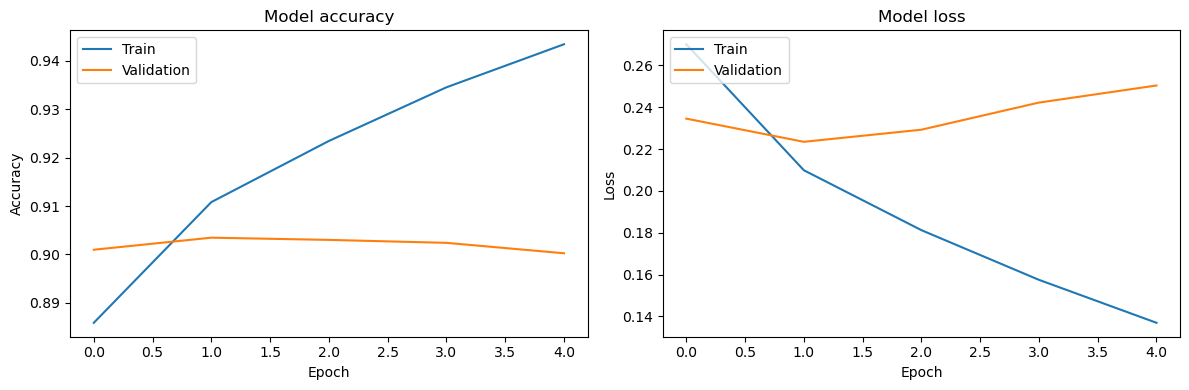

In [53]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyCNNTanh2.history['accuracy'])
plt.plot(historyCNNTanh2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyCNNTanh2.history['loss'])
plt.plot(historyCNNTanh2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



In [54]:
#cnnn sigmoid with unclean data

modelCNNSigmoid2 = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # CNN layer
    tf.keras.layers.Conv1D(64, 5, activation='tanh'),
    tf.keras.layers.MaxPooling1D(pool_size=4),

     # Flatten layer
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(64, activation='tanh'),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelCNNSigmoid2.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 32)           320000    
                                                                 
 conv1d_13 (Conv1D)          (None, 96, 64)            10304     
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 24, 64)            0         


 ng1D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 1536)              0         
                                                                 
 dense_17 (Dense)            (None, 64)                98368     
                                                                 
 dense_18 (Dense)            (None, 3)                 195       
                                                                 
Total params: 428867 (1.64 MB)
Trainable params: 428867 (1.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
#compile  adn trian

modelCNNSigmoid2.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

historyCNNSigmoid2 = modelCNNSigmoid2.fit(X_train_unclean, Y_train_unclean,
                    validation_data=(X_val_unclean, Y_val_unclean),
                    epochs=5,  
                    batch_size=128)

Epoch 1/5
4297/4297 [==============================] - 94s 21ms/step - loss: 0.2726 - accuracy: 0.8848 - val_loss: 0.2409 - val_accuracy: 0.8971
Epoch 2/5
4297/4297 [==============================] - 91s 21ms/step - loss: 0.2103 - accuracy: 0.9106 - val_loss: 0.2308 - val_accuracy: 0.9016
Epoch 3/5
4297/4297 [==============================] - 92s 21ms/step - loss: 0.1812 - accuracy: 0.9237 - val_loss: 0.2295 - val_accuracy: 0.9021
Epoch 4/5
4297/4297 [==============================] - 92s 21ms/step - loss: 0.1565 - accuracy: 0.9351 - val_loss: 0.2405 - val_accuracy: 0.8982
Epoch 5/5
4297/4297 [==============================] - 91s 21ms/step - loss: 0.1373 - accuracy: 0.9434 - val_loss: 0.2592 - val_accuracy: 0.8983


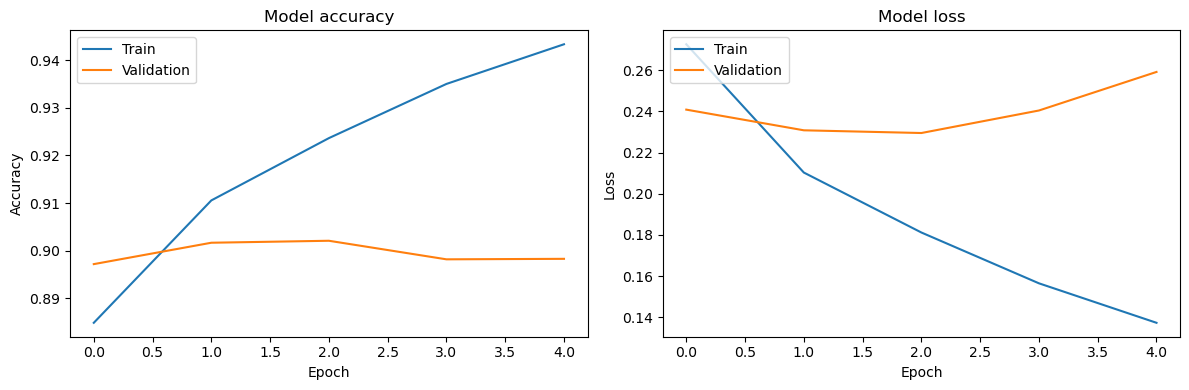

In [56]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyCNNSigmoid2.history['accuracy'])
plt.plot(historyCNNSigmoid2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyCNNSigmoid2.history['loss'])
plt.plot(historyCNNSigmoid2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [57]:
#save the models
modelCNNSigmoid2.save('CNN_model_Sigmoid2')
modelCNNTanh2.save('CNN_model_Tanh2')

INFO:tensorflow:Assets written to: CNN_model_Sigmoid2\assets


INFO:tensorflow:Assets written to: CNN_model_Sigmoid2\assets


INFO:tensorflow:Assets written to: CNN_model_Tanh2\assets


INFO:tensorflow:Assets written to: CNN_model_Tanh2\assets


In [47]:
modelLSTM2 = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # LSTM layers
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelLSTM2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 100, 32)           320000    
                                                                 
 lstm_30 (LSTM)              (None, 100, 64)           24832     
                                                                 
 lstm_31 (LSTM)              (None, 32)                12416     
                                                                 
 dense_21 (Dense)            (None, 3)                 99        
                                                                 
Total params: 357347 (1.36 MB)
Trainable params: 357347 (1.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
#train on unclean
modelLSTM2.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

historyLSTM2 = modelLSTM2.fit(X_train_unclean, Y_train_unclean,
                    validation_data=(X_val_unclean, Y_val_unclean),
                    epochs=5,  
                    batch_size=128)

Epoch 1/5
4297/4297 [==============================] - 1131s 262ms/step - loss: 0.2592 - accuracy: 0.8881 - val_loss: 0.2441 - val_accuracy: 0.8987
Epoch 2/5
4297/4297 [==============================] - 1108s 258ms/step - loss: 0.2019 - accuracy: 0.9120 - val_loss: 0.2065 - val_accuracy: 0.9081
Epoch 3/5
4297/4297 [==============================] - 1097s 255ms/step - loss: 0.1902 - accuracy: 0.9164 - val_loss: 0.2060 - val_accuracy: 0.9097
Epoch 4/5
4297/4297 [==============================] - 1099s 256ms/step - loss: 0.1816 - accuracy: 0.9200 - val_loss: 0.2036 - val_accuracy: 0.9108
Epoch 5/5
4297/4297 [==============================] - 1100s 256ms/step - loss: 0.1737 - accuracy: 0.9235 - val_loss: 0.2072 - val_accuracy: 0.9098


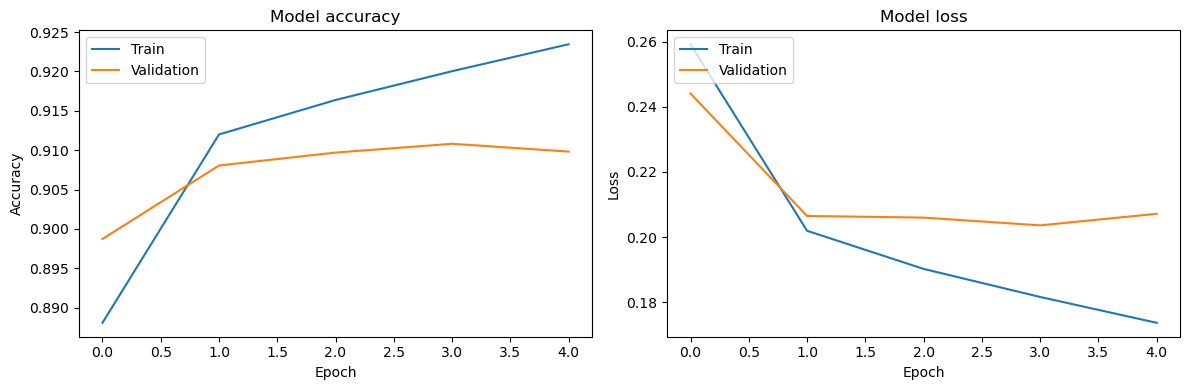

In [76]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyLSTM2.history['accuracy'])
plt.plot(historyLSTM2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyLSTM2.history['loss'])
plt.plot(historyLSTM2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [49]:
modelLSTMBi2 = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # Bidirectional LSTM layers
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelLSTMBi2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 100, 32)           320000    
                                                                 
 bidirectional_26 (Bidirect  (None, 100, 128)          49664     
 ional)                                                          
                                                                 
 bidirectional_27 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dense_22 (Dense)            (None, 3)                 195       
                                                                 
Total params: 411075 (1.57 MB)
Trainable params: 411075 (1.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
#train on unclean
modelLSTMBi2.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

historyLSTMBi2 = modelLSTMBi2.fit(X_train_unclean, Y_train_unclean,
                    validation_data=(X_val_unclean, Y_val_unclean),
                    epochs=5,  
                    batch_size=128)

Epoch 1/5
4297/4297 [==============================] - 2317s 537ms/step - loss: 0.2639 - accuracy: 0.8862 - val_loss: 0.2215 - val_accuracy: 0.9029
Epoch 2/5
4297/4297 [==============================] - 2310s 538ms/step - loss: 0.2013 - accuracy: 0.9121 - val_loss: 0.2055 - val_accuracy: 0.9090
Epoch 3/5
4297/4297 [==============================] - 36827s 9s/step - loss: 0.1884 - accuracy: 0.9173 - val_loss: 0.2033 - val_accuracy: 0.9104
Epoch 4/5
4297/4297 [==============================] - 2490s 579ms/step - loss: 0.1787 - accuracy: 0.9213 - val_loss: 0.2071 - val_accuracy: 0.9092
Epoch 5/5
4297/4297 [==============================] - 2321s 540ms/step - loss: 0.1705 - accuracy: 0.9249 - val_loss: 0.2074 - val_accuracy: 0.9100


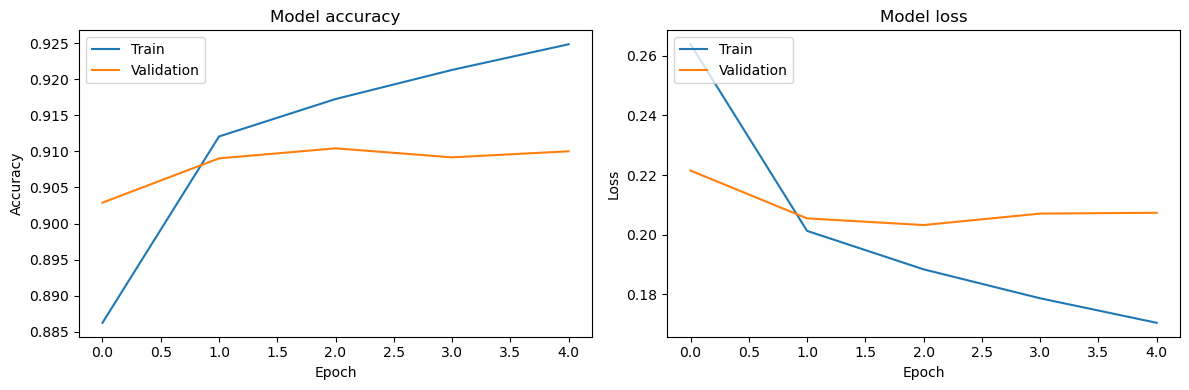

In [77]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyLSTMBi2.history['accuracy'])
plt.plot(historyLSTMBi2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyLSTMBi2.history['loss'])
plt.plot(historyLSTMBi2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [58]:

# Input layer
inputs = tf.keras.Input(shape=(max_len,))
x = tf.keras.layers.Embedding(input_dim=10000, output_dim=32)(inputs)

# LSTM layers
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(x)

# MultiHeadAttention layer
mha_layer = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=32)
attention_output = mha_layer(x, x) 
# Add a GlobalAveragePooling1D layer after the Attention layer
pooled = tf.keras.layers.GlobalAveragePooling1D()(attention_output)

# Output layer
outputs = tf.keras.layers.Dense(3, activation='softmax')(pooled)

# Create model
modelLSTMAttention2 = tf.keras.Model(inputs=inputs, outputs=outputs)

# Print the model summary
modelLSTMAttention2.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 100, 32)              320000    ['input_4[0][0]']             
                                                                                                  
 bidirectional_6 (Bidirecti  (None, 100, 128)             49664     ['embedding_12[0][0]']        
 onal)                                                                                            
                                                                                                  
 bidirectional_7 (Bidirecti  (None, 100, 64)              41216     ['bidirectional_6[0][0]'

Epoch 1/5
4297/4297 [==============================] - 1553s 359ms/step - loss: 0.2821 - accuracy: 0.8771 - val_loss: 0.2138 - val_accuracy: 0.9056
Epoch 2/5
4297/4297 [==============================] - 1484s 345ms/step - loss: 0.1996 - accuracy: 0.9126 - val_loss: 0.2067 - val_accuracy: 0.9092
Epoch 3/5
4297/4297 [==============================] - 1512s 352ms/step - loss: 0.1875 - accuracy: 0.9174 - val_loss: 0.2053 - val_accuracy: 0.9080
Epoch 4/5
4297/4297 [==============================] - 1541s 359ms/step - loss: 0.1783 - accuracy: 0.9213 - val_loss: 0.2119 - val_accuracy: 0.9100
Epoch 5/5
4297/4297 [==============================] - 1373s 319ms/step - loss: 0.1696 - accuracy: 0.9251 - val_loss: 0.2121 - val_accuracy: 0.9102


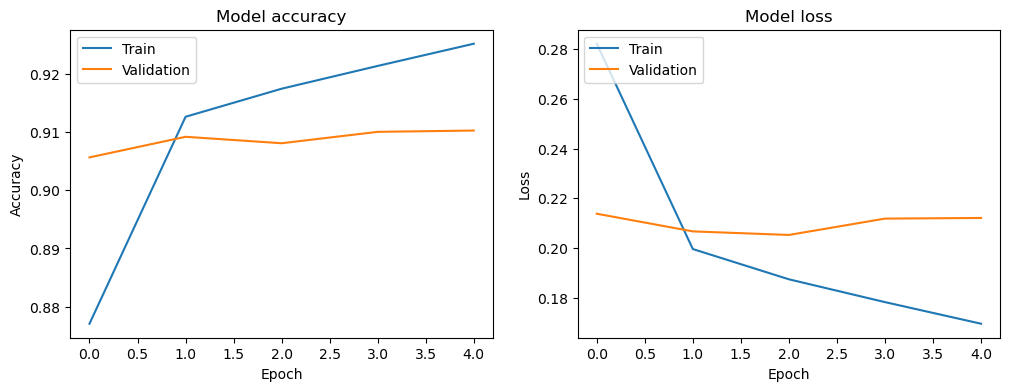

In [59]:
#compile and train
modelLSTMAttention2.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

historyLSTMAttention2 = modelLSTMAttention2.fit(X_train_unclean, Y_train_unclean,
                    validation_data=(X_val_unclean, Y_val_unclean),
                    epochs=5,  
                    batch_size=128)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyLSTMAttention2.history['accuracy'])
plt.plot(historyLSTMAttention2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyLSTMAttention2.history['loss'])
plt.plot(historyLSTMAttention2.history['val_loss'])
plt.title('Model loss')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper left')


In [60]:
# Input layer
inputs = tf.keras.Input(shape=(max_len,))
x = tf.keras.layers.Embedding(input_dim=10000, output_dim=32)(inputs)

# LSTM layers
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
mha_layer = tf.keras.layers.MultiHeadAttention(num_heads=3, key_dim=32)
attention_output = mha_layer(x, x) 
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(attention_output)
# Add a GlobalAveragePooling1D layer after the Attention layer
pooled = tf.keras.layers.GlobalAveragePooling1D()(x)

# Output layer
outputs = tf.keras.layers.Dense(3, activation='softmax')(pooled)

# Create model
modelLSTMAttentionBetween2 = tf.keras.Model(inputs=inputs, outputs=outputs)

# Print the model summary
modelLSTMAttentionBetween2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_13 (Embedding)    (None, 100, 32)              320000    ['input_5[0][0]']             
                                                                                                  
 bidirectional_8 (Bidirecti  (None, 100, 128)             49664     ['embedding_13[0][0]']        
 onal)                                                                                            
                                                                                                  
 multi_head_attention_3 (Mu  (None, 100, 128)             49568     ['bidirectional_8[0][0]'

Epoch 1/5
4297/4297 [==============================] - 1664s 385ms/step - loss: 0.2816 - accuracy: 0.8717 - val_loss: 0.2141 - val_accuracy: 0.9047
Epoch 2/5
4297/4297 [==============================] - 30800s 7s/step - loss: 0.1994 - accuracy: 0.9130 - val_loss: 0.2066 - val_accuracy: 0.9093
Epoch 3/5
4297/4297 [==============================] - 5137s 1s/step - loss: 0.1876 - accuracy: 0.9178 - val_loss: 0.2066 - val_accuracy: 0.9095
Epoch 4/5
4297/4297 [==============================] - 1776s 413ms/step - loss: 0.1789 - accuracy: 0.9217 - val_loss: 0.2069 - val_accuracy: 0.9097
Epoch 5/5
4297/4297 [==============================] - 3322s 773ms/step - loss: 0.1707 - accuracy: 0.9252 - val_loss: 0.2114 - val_accuracy: 0.9102


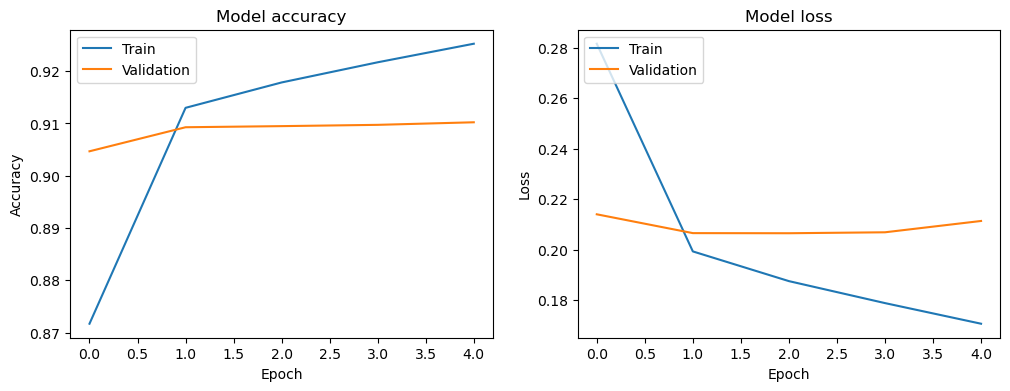

In [61]:
#compile and train
modelLSTMAttentionBetween2.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

historyLSTMAttentionBetween2 = modelLSTMAttentionBetween2.fit(X_train_unclean, Y_train_unclean,
                    validation_data=(X_val_unclean, Y_val_unclean),
                    epochs=5,  
                    batch_size=128)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyLSTMAttentionBetween2.history['accuracy'])
plt.plot(historyLSTMAttentionBetween2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyLSTMAttentionBetween2.history['loss'])
plt.plot(historyLSTMAttentionBetween2.history['val_loss'])
plt.title('Model loss')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper left')


In [62]:
#save models
modelLSTMAttentionBetween2.save('LSTM_Attention_Between_model2')
modelLSTMAttention2.save('LSTM_Attention_model2')

INFO:tensorflow:Assets written to: LSTM_Attention_Between_model2\assets


INFO:tensorflow:Assets written to: LSTM_Attention_Between_model2\assets


INFO:tensorflow:Assets written to: LSTM_Attention_model2\assets


INFO:tensorflow:Assets written to: LSTM_Attention_model2\assets


In [51]:
#making the best lstm model with attention
# Create the model 
inputs = tf.keras.Input(shape=(max_len,))
x = tf.keras.layers.Embedding(input_dim=10000, output_dim=32)(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
mha_layer = tf.keras.layers.MultiHeadAttention(num_heads=5, key_dim=32)
attention_output = mha_layer(x, x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(attention_output)
pooled = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(pooled)
modelLSTMAttentionBest2 = tf.keras.Model(inputs=inputs, outputs=outputs)

modelLSTMAttentionBest2.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 embedding_20 (Embedding)    (None, 100, 32)              320000    ['input_12[0][0]']            
                                                                                                  
 bidirectional_28 (Bidirect  (None, 100, 128)             49664     ['embedding_20[0][0]']        
 ional)                                                                                           
                                                                                                  
 multi_head_attention_11 (M  (None, 100, 128)             82528     ['bidirectional_28[0][0

In [52]:
#trani the model
modelLSTMAttentionBest2.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

historyLSTMAttentionBest2 = modelLSTMAttentionBest2.fit(X_train_unclean, Y_train_unclean,
                    validation_data=(X_val_unclean, Y_val_unclean),
                    epochs=5,  
                    batch_size=128)

Epoch 1/5
4297/4297 [==============================] - 1952s 453ms/step - loss: 0.2830 - accuracy: 0.8766 - val_loss: 0.2197 - val_accuracy: 0.9037
Epoch 2/5
4297/4297 [==============================] - 1831s 426ms/step - loss: 0.2039 - accuracy: 0.9116 - val_loss: 0.2061 - val_accuracy: 0.9094
Epoch 3/5
4297/4297 [==============================] - 1828s 425ms/step - loss: 0.1907 - accuracy: 0.9167 - val_loss: 0.2042 - val_accuracy: 0.9099
Epoch 4/5
4297/4297 [==============================] - 1833s 427ms/step - loss: 0.1821 - accuracy: 0.9205 - val_loss: 0.2061 - val_accuracy: 0.9104
Epoch 5/5
4297/4297 [==============================] - 37621s 9s/step - loss: 0.1745 - accuracy: 0.9238 - val_loss: 0.2151 - val_accuracy: 0.9096


In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(modelLSTMAttentionBest2.history['accuracy'])
plt.plot(modelLSTMAttentionBest2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(modelLSTMAttentionBest2.history['loss'])
plt.plot(modelLSTMAttentionBest2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Lets test the models if they work better deeper or wider

In [13]:
#CNN model wider
modelCNNWide = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=64, input_length=max_len),

    # CNN layer
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),

     # Flatten layer
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(128, activation='relu'),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])

modelCNNWide.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           41088     
                                                                 
 max_pooling1d (MaxPooling1  (None, 24, 128)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                        

In [14]:
#train on clean
modelCNNWide.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

historyCNNWide = modelCNNWide.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)

Epoch 1/5
4297/4297 [==============================] - 151s 35ms/step - loss: 0.2508 - accuracy: 0.8922 - val_loss: 0.2172 - val_accuracy: 0.9063
Epoch 2/5
4297/4297 [==============================] - 153s 36ms/step - loss: 0.1995 - accuracy: 0.9143 - val_loss: 0.2125 - val_accuracy: 0.9073
Epoch 3/5
4297/4297 [==============================] - 150s 35ms/step - loss: 0.1766 - accuracy: 0.9245 - val_loss: 0.2206 - val_accuracy: 0.9072
Epoch 4/5
4297/4297 [==============================] - 150s 35ms/step - loss: 0.1516 - accuracy: 0.9362 - val_loss: 0.2371 - val_accuracy: 0.9041
Epoch 5/5
4297/4297 [==============================] - 150s 35ms/step - loss: 0.1276 - accuracy: 0.9466 - val_loss: 0.2717 - val_accuracy: 0.9026


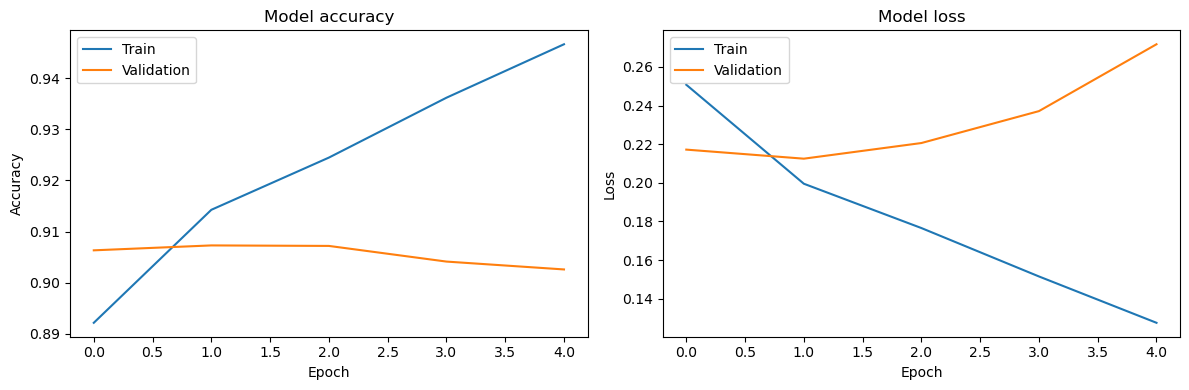

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyCNNWide.history['accuracy'])
plt.plot(historyCNNWide.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyCNNWide.history['loss'])
plt.plot(historyCNNWide.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
#CNN model depper

modelCNNDeep = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # CNN layer
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
   
    # Add another CNN layer
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),

      # Flatten layer
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(64, activation='relu'),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])

modelCNNDeep.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           320000    
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 24, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 20, 64)            20544     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 5, 64)             0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 320)              

In [17]:
#train on clean
modelCNNDeep.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

historyCNNDeep = modelCNNDeep.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)

Epoch 1/5
4297/4297 [==============================] - 78s 18ms/step - loss: 0.2556 - accuracy: 0.8882 - val_loss: 0.2199 - val_accuracy: 0.9050
Epoch 2/5
4297/4297 [==============================] - 78s 18ms/step - loss: 0.2047 - accuracy: 0.9126 - val_loss: 0.2126 - val_accuracy: 0.9070
Epoch 3/5
4297/4297 [==============================] - 81s 19ms/step - loss: 0.1886 - accuracy: 0.9194 - val_loss: 0.2124 - val_accuracy: 0.9080
Epoch 4/5
4297/4297 [==============================] - 78s 18ms/step - loss: 0.1728 - accuracy: 0.9274 - val_loss: 0.2209 - val_accuracy: 0.9044
Epoch 5/5
4297/4297 [==============================] - 77s 18ms/step - loss: 0.1560 - accuracy: 0.9352 - val_loss: 0.2438 - val_accuracy: 0.9041


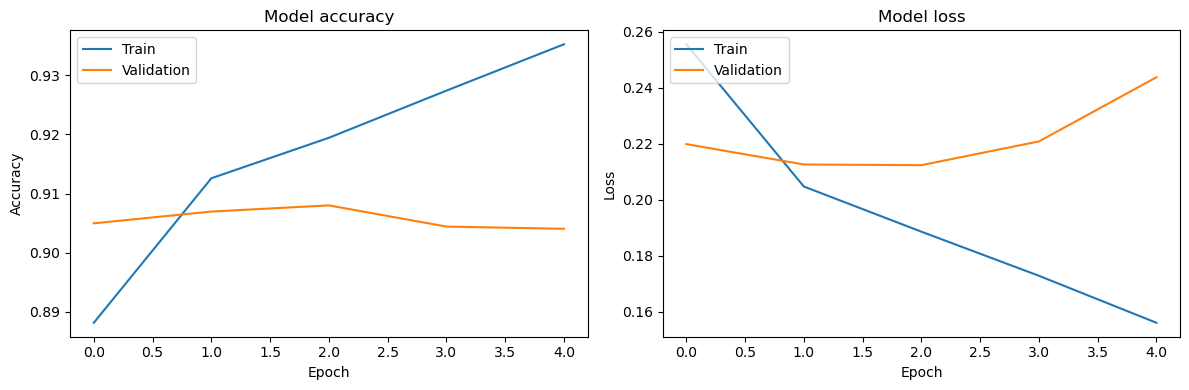

In [18]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyCNNDeep.history['accuracy'])
plt.plot(historyCNNDeep.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyCNNDeep.history['loss'])
plt.plot(historyCNNDeep.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [63]:
#cnn sigmoid wide
modelCNNSigmoidWide = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=64, input_length=max_len),

    # CNN layer
    tf.keras.layers.Conv1D(128, 5, activation='tanh'),
    tf.keras.layers.MaxPooling1D(pool_size=4),

     # Flatten layer
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(128, activation='tanh'),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelCNNSigmoidWide.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 100, 64)           640000    
                                                                 
 conv1d_14 (Conv1D)          (None, 96, 128)           41088     
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 24, 128)           0         
 ng1D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 3072)              0         
                                                                 
 dense_21 (Dense)            (None, 128)               393344    
                                                                 
 dense_22 (Dense)            (None, 3)                 387       
                                                      

Epoch 1/5
4297/4297 [==============================] - 264s 61ms/step - loss: 0.2712 - accuracy: 0.8860 - val_loss: 0.2430 - val_accuracy: 0.8984
Epoch 2/5
4297/4297 [==============================] - 248s 58ms/step - loss: 0.2107 - accuracy: 0.9113 - val_loss: 0.2239 - val_accuracy: 0.9035
Epoch 3/5
4297/4297 [==============================] - 253s 59ms/step - loss: 0.1778 - accuracy: 0.9260 - val_loss: 0.2310 - val_accuracy: 0.9033
Epoch 4/5
4297/4297 [==============================] - 250s 58ms/step - loss: 0.1478 - accuracy: 0.9393 - val_loss: 0.2523 - val_accuracy: 0.9035
Epoch 5/5
4297/4297 [==============================] - 226s 53ms/step - loss: 0.1228 - accuracy: 0.9502 - val_loss: 0.2708 - val_accuracy: 0.8988


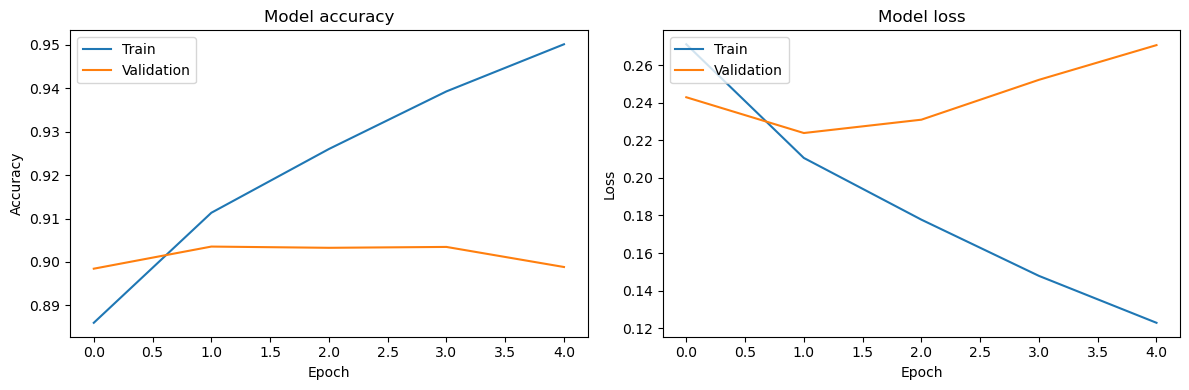

In [64]:
#train on clean
modelCNNSigmoidWide.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

historyCNNSigmoidWide = modelCNNSigmoidWide.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyCNNSigmoidWide.history['accuracy'])
plt.plot(historyCNNSigmoidWide.history['val_accuracy'])
plt.title('Model accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyCNNSigmoidWide.history['loss'])
plt.plot(historyCNNSigmoidWide.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()

In [65]:
#CNN sigmoid deep
modelCNNSigmoidDeep = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # CNN layer
    tf.keras.layers.Conv1D(64, 5, activation='tanh'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
   
    # Add another CNN layer
    tf.keras.layers.Conv1D(64, 5, activation='tanh'),
    tf.keras.layers.MaxPooling1D(pool_size=4),

      # Flatten layer
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(64, activation='tanh'),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelCNNSigmoidDeep.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 100, 32)           320000    
                                                                 
 conv1d_15 (Conv1D)          (None, 96, 64)            10304     
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 24, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_16 (Conv1D)          (None, 20, 64)            20544     
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 5, 64)             0         
 ng1D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 320)             

Epoch 1/5
4297/4297 [==============================] - 161s 37ms/step - loss: 0.2603 - accuracy: 0.8882 - val_loss: 0.2302 - val_accuracy: 0.9031
Epoch 2/5
4297/4297 [==============================] - 158s 37ms/step - loss: 0.2087 - accuracy: 0.9117 - val_loss: 0.2215 - val_accuracy: 0.9063
Epoch 3/5
4297/4297 [==============================] - 153s 36ms/step - loss: 0.1886 - accuracy: 0.9203 - val_loss: 0.2294 - val_accuracy: 0.9019
Epoch 4/5
4297/4297 [==============================] - 152s 35ms/step - loss: 0.1698 - accuracy: 0.9288 - val_loss: 0.2251 - val_accuracy: 0.9046
Epoch 5/5
4297/4297 [==============================] - 154s 36ms/step - loss: 0.1519 - accuracy: 0.9370 - val_loss: 0.2407 - val_accuracy: 0.9038


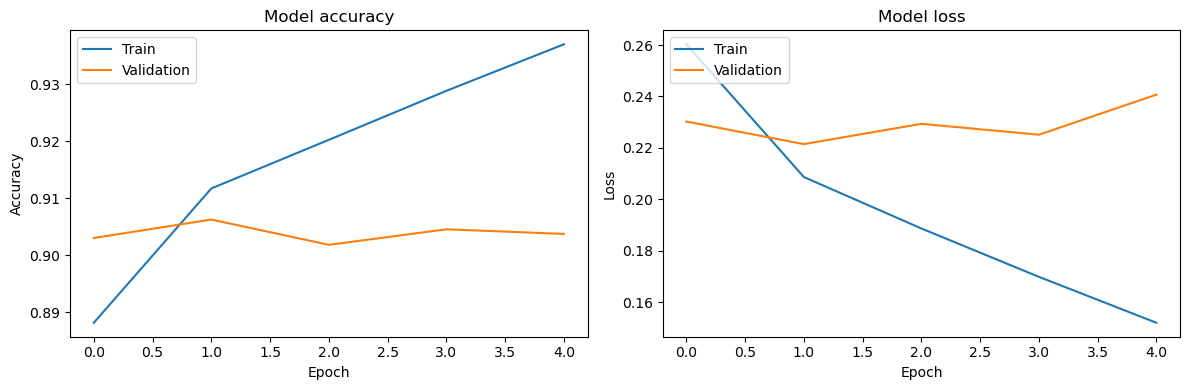

In [66]:
#train
modelCNNSigmoidDeep.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])


historyCNNSigmoidDeep = modelCNNSigmoidDeep.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyCNNSigmoidDeep.history['accuracy'])
plt.plot(historyCNNSigmoidDeep.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyCNNSigmoidDeep.history['loss'])
plt.plot(historyCNNSigmoidDeep.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()

In [67]:
#CNN tanh wide
modelCNNTanhWide = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=64, input_length=max_len),

    # CNN layer
    tf.keras.layers.Conv1D(128, 5, activation='tanh'),
    tf.keras.layers.MaxPooling1D(pool_size=4),

     # Flatten layer
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(128, activation='tanh'),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelCNNTanhWide.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 100, 64)           640000    
                                                                 
 conv1d_17 (Conv1D)          (None, 96, 128)           41088     
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 24, 128)           0         
 ng1D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 3072)              0         
                                                                 
 dense_25 (Dense)            (None, 128)               393344    
                                                                 
 dense_26 (Dense)            (None, 3)                 387       
                                                     

Epoch 1/5
4297/4297 [==============================] - 276s 64ms/step - loss: 0.2710 - accuracy: 0.8860 - val_loss: 0.2440 - val_accuracy: 0.8974
Epoch 2/5
4297/4297 [==============================] - 263s 61ms/step - loss: 0.2111 - accuracy: 0.9114 - val_loss: 0.2270 - val_accuracy: 0.9026
Epoch 3/5
4297/4297 [==============================] - 256s 60ms/step - loss: 0.1787 - accuracy: 0.9257 - val_loss: 0.2297 - val_accuracy: 0.9025
Epoch 4/5
4297/4297 [==============================] - 236s 55ms/step - loss: 0.1487 - accuracy: 0.9390 - val_loss: 0.2582 - val_accuracy: 0.8970
Epoch 5/5
4297/4297 [==============================] - 235s 55ms/step - loss: 0.1243 - accuracy: 0.9495 - val_loss: 0.2699 - val_accuracy: 0.8993


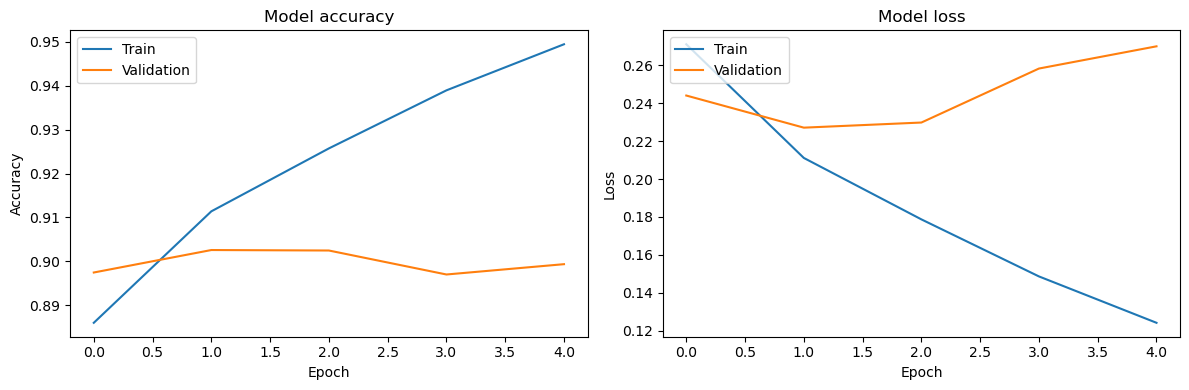

In [68]:
#train
modelCNNTanhWide.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

historyCNNTanhWide = modelCNNTanhWide.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyCNNTanhWide.history['accuracy'])
plt.plot(historyCNNTanhWide.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyCNNTanhWide.history['loss'])
plt.plot(historyCNNTanhWide.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()

In [69]:
#CNN tanh deep
modelCNNTanhDeep = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # CNN layer
    tf.keras.layers.Conv1D(64, 5, activation='tanh'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
   
    # Add another CNN layer
    tf.keras.layers.Conv1D(64, 5, activation='tanh'),
    tf.keras.layers.MaxPooling1D(pool_size=4),

      # Flatten layer
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(64, activation='tanh'),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])

modelCNNTanhDeep.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 32)           320000    
                                                                 
 conv1d_18 (Conv1D)          (None, 96, 64)            10304     
                                                                 
 max_pooling1d_18 (MaxPooli  (None, 24, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_19 (Conv1D)          (None, 20, 64)            20544     
                                                                 
 max_pooling1d_19 (MaxPooli  (None, 5, 64)             0         
 ng1D)                                                           
                                                                 
 flatten_14 (Flatten)        (None, 320)             

Epoch 1/5
4297/4297 [==============================] - 153s 35ms/step - loss: 0.2592 - accuracy: 0.8892 - val_loss: 0.2313 - val_accuracy: 0.9023
Epoch 2/5
4297/4297 [==============================] - 131s 30ms/step - loss: 0.2087 - accuracy: 0.9114 - val_loss: 0.2225 - val_accuracy: 0.9054
Epoch 3/5
4297/4297 [==============================] - 128s 30ms/step - loss: 0.1884 - accuracy: 0.9204 - val_loss: 0.2203 - val_accuracy: 0.9061
Epoch 4/5
4297/4297 [==============================] - 129s 30ms/step - loss: 0.1690 - accuracy: 0.9295 - val_loss: 0.2276 - val_accuracy: 0.9052
Epoch 5/5
4297/4297 [==============================] - 130s 30ms/step - loss: 0.1513 - accuracy: 0.9379 - val_loss: 0.2463 - val_accuracy: 0.9003


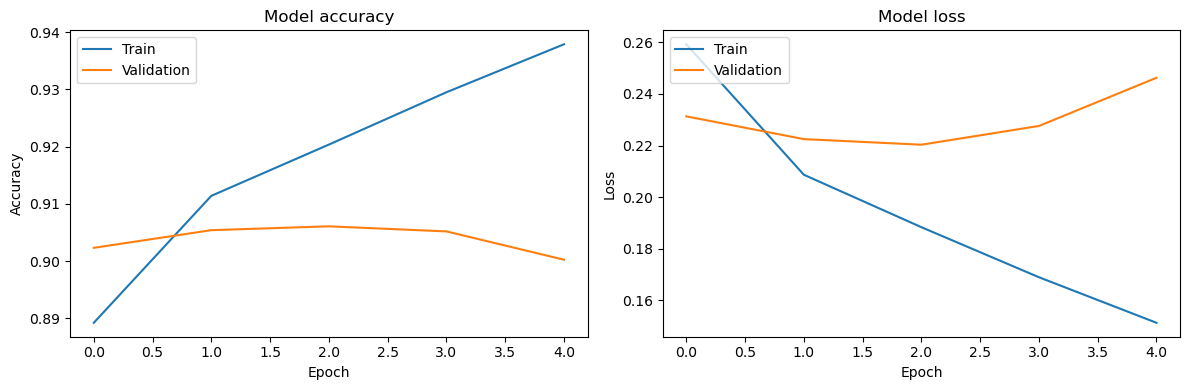

In [70]:
#train
modelCNNTanhDeep.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

historyCNNTanhDeep = modelCNNTanhDeep.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyCNNTanhDeep.history['accuracy'])
plt.plot(historyCNNTanhDeep.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyCNNTanhDeep.history['loss'])
plt.plot(historyCNNTanhDeep.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()

In [72]:
#save models

modelCNNSigmoidWide.save('CNN_model_Sigmoid_Wide')
modelCNNSigmoidDeep.save('CNN_model_Sigmoid_Deep')
modelCNNTanhWide.save('CNN_model_Tanh_Wide')
modelCNNTanhDeep.save('CNN_model_Tanh_Deep')

INFO:tensorflow:Assets written to: CNN_model_Sigmoid_Wide\assets


INFO:tensorflow:Assets written to: CNN_model_Sigmoid_Wide\assets


INFO:tensorflow:Assets written to: CNN_model_Sigmoid_Deep\assets


INFO:tensorflow:Assets written to: CNN_model_Sigmoid_Deep\assets


INFO:tensorflow:Assets written to: CNN_model_Tanh_Wide\assets


INFO:tensorflow:Assets written to: CNN_model_Tanh_Wide\assets


INFO:tensorflow:Assets written to: CNN_model_Tanh_Deep\assets


INFO:tensorflow:Assets written to: CNN_model_Tanh_Deep\assets


In [19]:
#LSTM Bidirectional wider

modelLSTMBiWide = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # Bidirectional LSTM layers
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelLSTMBiWide.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 32)           320000    
                                                                 
 bidirectional (Bidirection  (None, 100, 256)          164864    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
Total params: 649603 (2.48 MB)
Trainable params: 649603 (2.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
#train on clean

modelLSTMBiWide.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

historyLSTMBiWide = modelLSTMBiWide.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)

Epoch 1/5
4297/4297 [==============================] - 3704s 861ms/step - loss: 0.2707 - accuracy: 0.8844 - val_loss: 0.2193 - val_accuracy: 0.9047
Epoch 2/5
4297/4297 [==============================] - 4199s 977ms/step - loss: 0.2054 - accuracy: 0.9111 - val_loss: 0.2100 - val_accuracy: 0.9085
Epoch 3/5
4297/4297 [==============================] - 4260s 991ms/step - loss: 0.1932 - accuracy: 0.9161 - val_loss: 0.2068 - val_accuracy: 0.9093
Epoch 4/5
4297/4297 [==============================] - 4182s 973ms/step - loss: 0.1838 - accuracy: 0.9204 - val_loss: 0.2132 - val_accuracy: 0.9078
Epoch 5/5
4297/4297 [==============================] - 4157s 967ms/step - loss: 0.1744 - accuracy: 0.9247 - val_loss: 0.2126 - val_accuracy: 0.9088


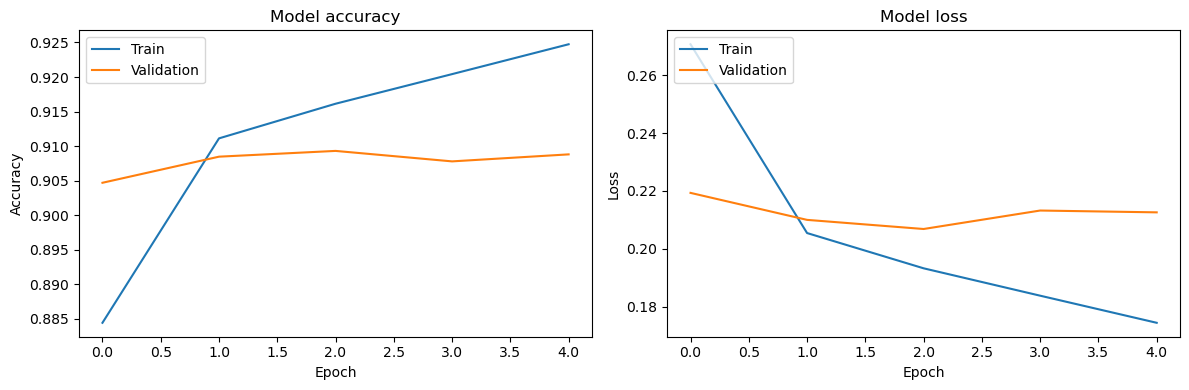

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyLSTMBiWide.history['accuracy'])
plt.plot(historyLSTMBiWide.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyLSTMBiWide.history['loss'])
plt.plot(historyLSTMBiWide.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [22]:
#LSTM Bidirectional deeper

modelLSTMBiDeep = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32, input_length=max_len),

    # Bidirectional LSTM layers
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),

    # Output layer
    tf.keras.layers.Dense(3, activation='softmax')
])
modelLSTMBiDeep.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 32)           320000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 128)          49664     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 100, 64)           41216     
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                      

In [23]:
#train on clean

modelLSTMBiDeep.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

historyLSTMBiDeep = modelLSTMBiDeep.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)

Epoch 1/5
4297/4297 [==============================] - 1177s 272ms/step - loss: 0.2781 - accuracy: 0.8814 - val_loss: 0.2247 - val_accuracy: 0.9037
Epoch 2/5
4297/4297 [==============================] - 1142s 266ms/step - loss: 0.2076 - accuracy: 0.9107 - val_loss: 0.2111 - val_accuracy: 0.9090
Epoch 3/5
4297/4297 [==============================] - 1174s 273ms/step - loss: 0.1936 - accuracy: 0.9163 - val_loss: 0.2102 - val_accuracy: 0.9094
Epoch 4/5
4297/4297 [==============================] - 1171s 272ms/step - loss: 0.1844 - accuracy: 0.9201 - val_loss: 0.2116 - val_accuracy: 0.9091
Epoch 5/5
4297/4297 [==============================] - 1183s 275ms/step - loss: 0.1760 - accuracy: 0.9238 - val_loss: 0.2151 - val_accuracy: 0.9085


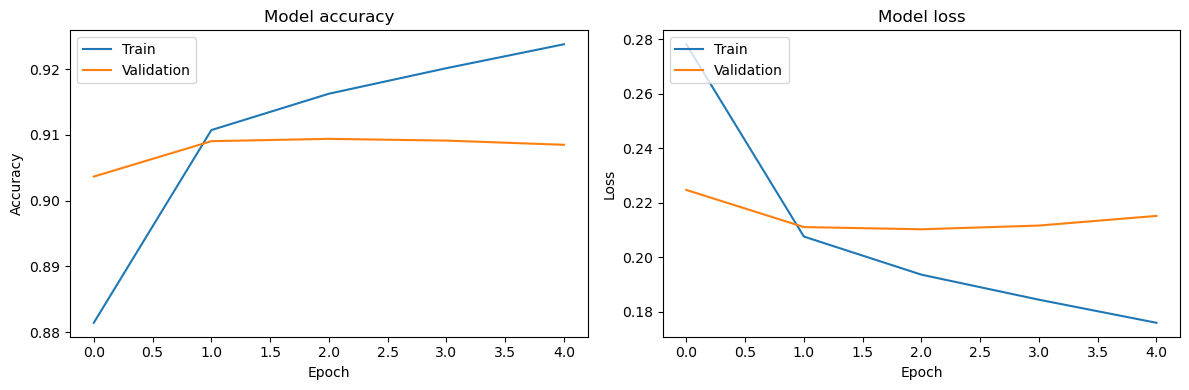

In [24]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyLSTMBiDeep.history['accuracy'])
plt.plot(historyLSTMBiDeep.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyLSTMBiDeep.history['loss'])
plt.plot(historyLSTMBiDeep.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [25]:
#LSTM with attention layer wider

# Create the model

inputs = tf.keras.Input(shape=(max_len,))
x = tf.keras.layers.Embedding(input_dim=10000, output_dim=32)(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
mha_layer = tf.keras.layers.MultiHeadAttention(num_heads=20, key_dim=32)
attention_output = mha_layer(x, x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(attention_output)
pooled = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(pooled)
modelLSTMAttentionWide = tf.keras.Model(inputs=inputs, outputs=outputs)

modelLSTMAttentionWide.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 100, 32)              320000    ['input_1[0][0]']             
                                                                                                  
 bidirectional_5 (Bidirecti  (None, 100, 256)             164864    ['embedding_4[0][0]']         
 onal)                                                                                            
                                                                                                  
 multi_head_attention (Mult  (None, 100, 256)             657536    ['bidirectional_5[0][0]', 

In [26]:
#train on clean

modelLSTMAttentionWide.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

historyLSTMAttentionWide = modelLSTMAttentionWide.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)

Epoch 1/5
4297/4297 [==============================] - 6839s 2s/step - loss: 0.3112 - accuracy: 0.8631 - val_loss: 0.2245 - val_accuracy: 0.9043
Epoch 2/5
4297/4297 [==============================] - 6817s 2s/step - loss: 0.2137 - accuracy: 0.9084 - val_loss: 0.2175 - val_accuracy: 0.9061
Epoch 3/5
4297/4297 [==============================] - 6916s 2s/step - loss: 0.2064 - accuracy: 0.9115 - val_loss: 0.2188 - val_accuracy: 0.9063
Epoch 4/5
4297/4297 [==============================] - 6945s 2s/step - loss: 0.2006 - accuracy: 0.9143 - val_loss: 0.2149 - val_accuracy: 0.9059
Epoch 5/5
4297/4297 [==============================] - 7086s 2s/step - loss: 0.1985 - accuracy: 0.9148 - val_loss: 0.2156 - val_accuracy: 0.9070


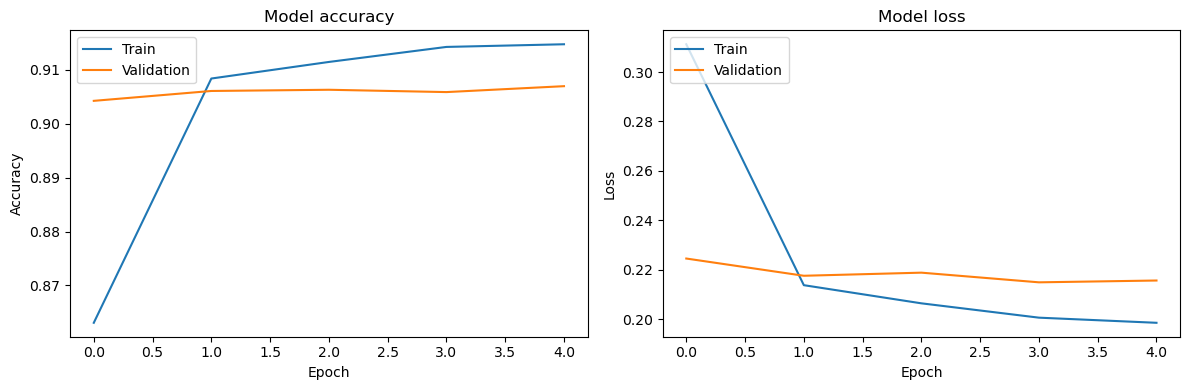

In [27]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyLSTMAttentionWide.history['accuracy'])
plt.plot(historyLSTMAttentionWide.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyLSTMAttentionWide.history['loss'])
plt.plot(historyLSTMAttentionWide.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [28]:
#LSTM with attention layer deeper

# Create the model

inputs = tf.keras.Input(shape=(max_len,))
x = tf.keras.layers.Embedding(input_dim=10000, output_dim=32)(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
mha_layer = tf.keras.layers.MultiHeadAttention(num_heads=20, key_dim=32)
attention_output = mha_layer(x, x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(attention_output)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True))(x)
pooled = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(pooled)
modelLSTMAttentionDeep = tf.keras.Model(inputs=inputs, outputs=outputs)

modelLSTMAttentionDeep.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 100, 32)              320000    ['input_2[0][0]']             
                                                                                                  
 bidirectional_7 (Bidirecti  (None, 100, 128)             49664     ['embedding_5[0][0]']         
 onal)                                                                                            
                                                                                                  
 multi_head_attention_1 (Mu  (None, 100, 128)             329728    ['bidirectional_7[0][0]'

In [29]:
#train on clean

modelLSTMAttentionDeep.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

historyLSTMAttentionDeep = modelLSTMAttentionDeep.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=128)

Epoch 1/5
4297/4297 [==============================] - 4379s 1s/step - loss: 0.2959 - accuracy: 0.8697 - val_loss: 0.2209 - val_accuracy: 0.9046
Epoch 2/5
4297/4297 [==============================] - 4382s 1s/step - loss: 0.2102 - accuracy: 0.9097 - val_loss: 0.2187 - val_accuracy: 0.9024
Epoch 3/5
4297/4297 [==============================] - 4587s 1s/step - loss: 0.2008 - accuracy: 0.9138 - val_loss: 0.2194 - val_accuracy: 0.9035
Epoch 4/5
4297/4297 [==============================] - 4467s 1s/step - loss: 0.1952 - accuracy: 0.9158 - val_loss: 0.2137 - val_accuracy: 0.9064
Epoch 5/5
4297/4297 [==============================] - 4278s 996ms/step - loss: 0.1898 - accuracy: 0.9183 - val_loss: 0.2159 - val_accuracy: 0.9064


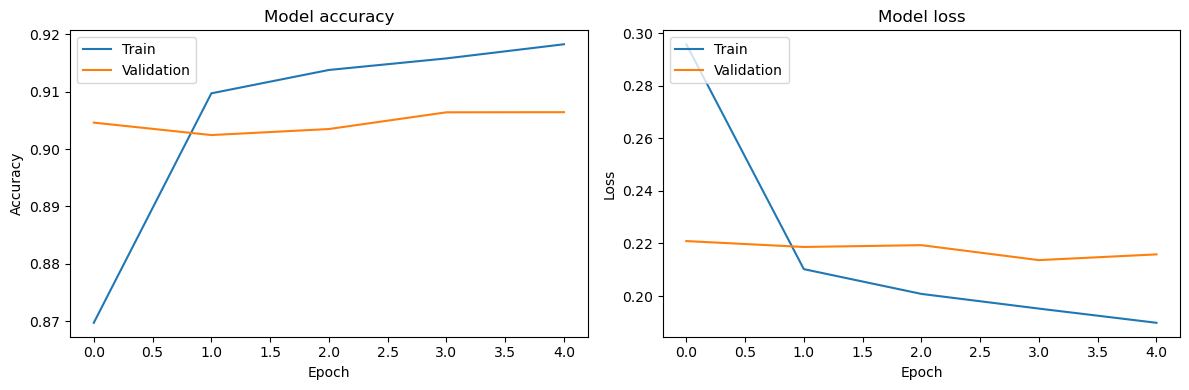

In [30]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyLSTMAttentionDeep.history['accuracy'])
plt.plot(historyLSTMAttentionDeep.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyLSTMAttentionDeep.history['loss'])
plt.plot(historyLSTMAttentionDeep.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [32]:
#save the models
modelCNNWide.save('CNN_modelWide')
modelCNNDeep.save('CNN_modelDeep')
modelLSTMBiWide.save('LSTM_Bi_modelWide')
modelLSTMBiDeep.save('LSTM_Bi_modelDeep')
modelLSTMAttentionWide.save('LSTM_Attention_modelWide')
modelLSTMAttentionDeep.save('LSTM_Attention_modelDeep')


INFO:tensorflow:Assets written to: CNN_modelWide\assets


INFO:tensorflow:Assets written to: CNN_modelWide\assets


INFO:tensorflow:Assets written to: CNN_modelDeep\assets


INFO:tensorflow:Assets written to: CNN_modelDeep\assets


INFO:tensorflow:Assets written to: LSTM_Bi_modelWide\assets


INFO:tensorflow:Assets written to: LSTM_Bi_modelWide\assets


INFO:tensorflow:Assets written to: LSTM_Bi_modelDeep\assets


INFO:tensorflow:Assets written to: LSTM_Bi_modelDeep\assets


INFO:tensorflow:Assets written to: LSTM_Attention_modelWide\assets


INFO:tensorflow:Assets written to: LSTM_Attention_modelWide\assets


INFO:tensorflow:Assets written to: LSTM_Attention_modelDeep\assets


INFO:tensorflow:Assets written to: LSTM_Attention_modelDeep\assets


Lets build an CNN plus LSTM uisng my best performing ones

In [11]:
# Input layer
inputs = tf.keras.Input(shape=(max_len,))

# CNN model for feature extraction
x = tf.keras.layers.Embedding(input_dim=10000, output_dim=32)(inputs)
x = tf.keras.layers.Conv1D(64, 5, activation='sigmoid')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=4)(x)
x = tf.keras.layers.Conv1D(64, 5, activation='sigmoid')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=4)(x)
cnn_features = tf.keras.layers.Flatten()(x)

# LSTM model with attention
x = tf.keras.layers.Reshape((5, 64))(cnn_features)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)

# Output layer
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

# Combine models
CNN_LSTM_model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Summary
CNN_LSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            10304     
                                                                 
 max_pooling1d (MaxPooling1  (None, 24, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            20544     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 64)             0         
 g1D)                                                        

In [13]:
# Compile the model
CNN_LSTM_model.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
# Train the model
historyCNN_LSTM = CNN_LSTM_model.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=32)

Epoch 1/5
17186/17186 [==============================] - 345s 20ms/step - loss: 0.3286 - accuracy: 0.8527 - val_loss: 0.2297 - val_accuracy: 0.9008
Epoch 2/5
17186/17186 [==============================] - 299s 17ms/step - loss: 0.2160 - accuracy: 0.9079 - val_loss: 0.2250 - val_accuracy: 0.9049
Epoch 3/5
17186/17186 [==============================] - 296s 17ms/step - loss: 0.2025 - accuracy: 0.9143 - val_loss: 0.2183 - val_accuracy: 0.9064
Epoch 4/5
17186/17186 [==============================] - 298s 17ms/step - loss: 0.1902 - accuracy: 0.9197 - val_loss: 0.2148 - val_accuracy: 0.9078
Epoch 5/5
17186/17186 [==============================] - 299s 17ms/step - loss: 0.1778 - accuracy: 0.9260 - val_loss: 0.2226 - val_accuracy: 0.9060


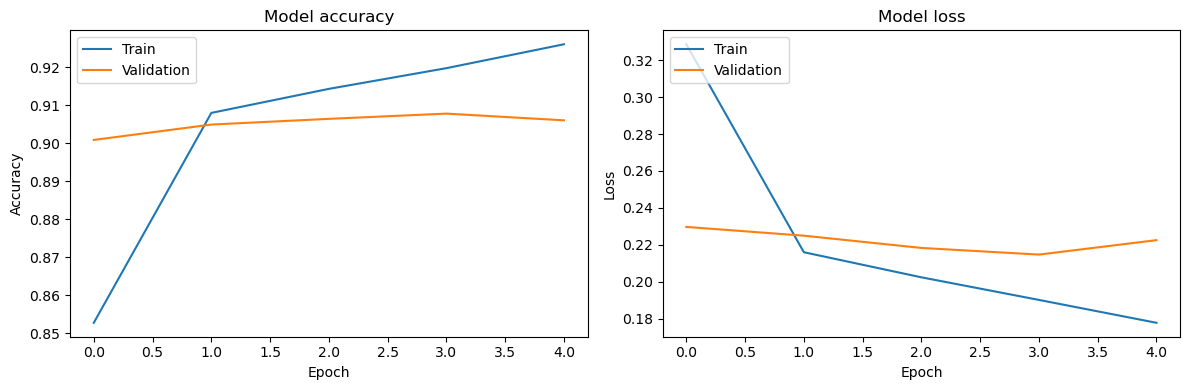

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyCNN_LSTM.history['accuracy'])
plt.plot(historyCNN_LSTM.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyCNN_LSTM.history['loss'])
plt.plot(historyCNN_LSTM.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
# Input layer
inputs = tf.keras.Input(shape=(max_len,))

# LSTM model
x = tf.keras.layers.Embedding(input_dim=10000, output_dim=32)(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)

# CNN model for feature extraction
x = tf.keras.layers.Conv1D(64, 5, activation='sigmoid')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=4)(x)
x = tf.keras.layers.Conv1D(64, 5, activation='sigmoid')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=4)(x)
x = tf.keras.layers.Flatten()(x)

# Output layer
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

# Combine models
LSTM_CNN_model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Summary
LSTM_CNN_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 32)           320000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 256)          164864    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 100, 128)          164352    
 onal)                                                           
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 64)            41024     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 24, 64)            0   

In [17]:
# Compile the model
LSTM_CNN_model.compile(loss='sparse_categorical_crossentropy',  
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
# Train the model
historyLSTM_CNN = LSTM_CNN_model.fit(X_train_clean, Y_train_clean,
                    validation_data=(X_val_clean, Y_val_clean),
                    epochs=5,  
                    batch_size=32)

Epoch 1/5
17186/17186 [==============================] - 2615s 152ms/step - loss: 0.2881 - accuracy: 0.8770 - val_loss: 0.2199 - val_accuracy: 0.9059
Epoch 2/5
17186/17186 [==============================] - 2569s 149ms/step - loss: 0.2089 - accuracy: 0.9100 - val_loss: 0.2104 - val_accuracy: 0.9094
Epoch 3/5
17186/17186 [==============================] - 2567s 149ms/step - loss: 0.1975 - accuracy: 0.9152 - val_loss: 0.2081 - val_accuracy: 0.9090
Epoch 4/5
17186/17186 [==============================] - 2567s 149ms/step - loss: 0.1893 - accuracy: 0.9191 - val_loss: 0.2092 - val_accuracy: 0.9101
Epoch 5/5
17186/17186 [==============================] - 2577s 150ms/step - loss: 0.1821 - accuracy: 0.9226 - val_loss: 0.2085 - val_accuracy: 0.9102


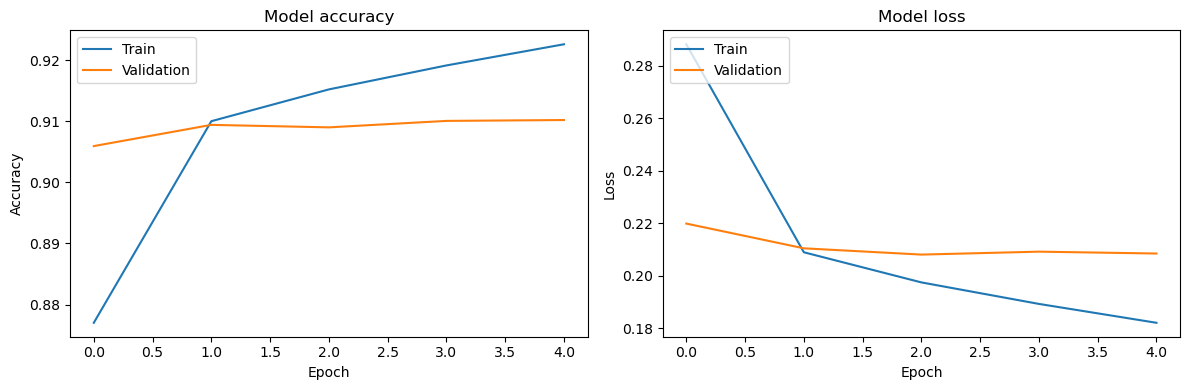

In [19]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyLSTM_CNN.history['accuracy'])
plt.plot(historyLSTM_CNN.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyLSTM_CNN.history['loss'])
plt.plot(historyLSTM_CNN.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [20]:
# Save the LSTM_CNN_model
LSTM_CNN_model.save('LSTM_CNN_model')

# Save the CNN_LSTM_model
CNN_LSTM_model.save('CNN_LSTM_model')

INFO:tensorflow:Assets written to: LSTM_CNN_model\assets


INFO:tensorflow:Assets written to: LSTM_CNN_model\assets


INFO:tensorflow:Assets written to: CNN_LSTM_model\assets


INFO:tensorflow:Assets written to: CNN_LSTM_model\assets


In [26]:
LSTM_CNN_model_unclean = tf.keras.models.clone_model(LSTM_CNN_model)

# Concatenate the training data
X_train_combined = np.concatenate((X_train_clean, X_train_unclean), axis=0)
Y_train_combined = np.concatenate((Y_train_clean, Y_train_unclean), axis=0)

# Concatenate the validation data
X_val_combined = np.concatenate((X_val_clean, X_val_unclean), axis=0)
Y_val_combined = np.concatenate((Y_val_clean, Y_val_unclean), axis=0)


LSTM_CNN_model_unclean.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# Train the model on the combined data
historyLSTM_CNN_combined = LSTM_CNN_model_unclean.fit(X_train_combined, Y_train_combined,
                    validation_data=(X_val_combined, Y_val_combined),
                    epochs=5,  
                    batch_size=32)

Epoch 1/5
34372/34372 [==============================] - 4874s 142ms/step - loss: 0.3576 - accuracy: 0.8425 - val_loss: 0.2233 - val_accuracy: 0.9017
Epoch 2/5
34372/34372 [==============================] - 5876s 171ms/step - loss: 0.2084 - accuracy: 0.9095 - val_loss: 0.2119 - val_accuracy: 0.9077
Epoch 3/5
34372/34372 [==============================] - 5478s 159ms/step - loss: 0.1956 - accuracy: 0.9153 - val_loss: 0.2111 - val_accuracy: 0.9079
Epoch 4/5
34372/34372 [==============================] - 5329s 155ms/step - loss: 0.1875 - accuracy: 0.9191 - val_loss: 0.2107 - val_accuracy: 0.9094
Epoch 5/5
34372/34372 [==============================] - 5289s 154ms/step - loss: 0.1806 - accuracy: 0.9223 - val_loss: 0.2099 - val_accuracy: 0.9087


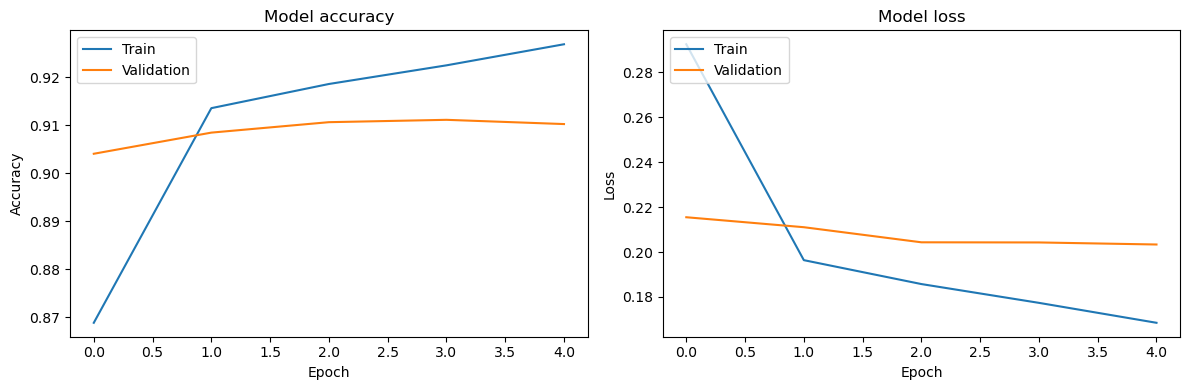

In [27]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historyLSTM_CNN_unclean.history['accuracy'])
plt.plot(historyLSTM_CNN_unclean.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(historyLSTM_CNN_unclean.history['loss'])
plt.plot(historyLSTM_CNN_unclean.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [28]:
# Save the LSTM_CNN_model_unclean
LSTM_CNN_model_unclean.save('LSTM_CNN_model_unclean')

INFO:tensorflow:Assets written to: LSTM_CNN_model_unclean\assets


INFO:tensorflow:Assets written to: LSTM_CNN_model_unclean\assets
